# Selección de cripto activos para una cartera de inversión

# Trabajo Práctico 5 - Aprendizaje No Supervisado

# Introducción

En finanzas, encontrar grupos de activos similares o regímenes en el comportamiento de los precios es de mucha utilidad, y es de gran ayuda en el desarrollo de filtros, definición de reglas de compra/venta, etc. 

En este práctico aplicaremos métodos de aprendizaje no supervisado. Estas metodologías en muchos casos son aplicadas antes de las de aprendizaje supervisado, dado que frecuentemente nos permiten obtener información útil de nuestros datos.

Podemos destacar métodos como clustering y reducción de dimensionalidad. Algunas de las metodologías despliegan su máximo potencial cuando se dispone de muchas series.

# ¡Actividades!

Analizaremos las variaciones (tasas de cambio) de los activos en ventanas específicas de tiempo. Nuestro objetivo será encontrar activos con comportamiento similiar en términos de sus retornos.

Para esta actividad seleccionen periodos en los cuales esté disponible la data de todos los activos. 

## Parte I - Clustering

- Aplicar el algoritmo Mean Shift. En este caso se pueden usar los criterios de información (codo o silueta) como guía para determinar la cantidad óptima de clusters.

- Aplicar k-means. Seleccionar el valor de k de acuerdo a la inercia o el análisis de siluetas.

- Aplicar un algoritmo de clustering jeráquico.

¿Encuentran grandes diferencias entre un periodo donde Bitcoin está al alza y uno donde está a la baja? 

## Parte II - Embeddings

- Aplicar el análisis de componentes principales con las tasas de rendimiento y con las tasas de rendimiento previamente estandarizadas.

En ambos casos, comenten los resultados brevemente.


# Fecha de entrega

- __Versión preliminar: 22/10__ 

- __Versión final: 29/10__

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis desarrollado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 

# **Resolución**

##**Importaciones**

In [ ]:
import pandas as pd
import numpy as np

#Escaladores
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

#Tecnicas de Clustering y graficadores
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score

#Para la carga de los datos
import os
import re
import requests

#Graficadores
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go

#Estudio de Nulos
import missingno as msno

#PCA
from sklearn.decomposition import PCA


In [ ]:
#Para eliminar algunas warnings que aparecen
import warnings
warnings.filterwarnings("ignore")

**Instalación de Time Series Learn**

In [ ]:
!pip install tslearn

     |████████████████████████████████| 793 kB 2.7 MB/s 


**Instalación de yellowbrick para graficos de siluetas**

In [ ]:
pip install -U yellowbrick

     |████████████████████████████████| 271 kB 2.7 MB/s 
  Attempting uninstall: yellowbrick
    Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [ ]:
#Importaciones de time series learn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from tslearn.utils import to_time_series_dataset

##**Funciones**
https://stackoverflow.com/questions/26941135/show-legend-and-label-axes-in-plotly-3d-scatter-plots

**Función para Graficar clusters en 3D**

In [ ]:
#Función para Graficar clusters en 3D

def plot_clustering(df, centersDF=pd.DataFrame()):

    pltWidth = 800
    pltHeight = 800
    
    pEvalData = df#.toPandas() para spark

    if not(centersDF.empty):

        pEvalCenters = centersDF#.toPandas()

        eData = go.Scatter3d(
            x=pEvalData.x,
            y=pEvalData.y,
            z=pEvalData.z,
            showlegend=False,
            mode='markers',
            text=pEvalData.name,
            marker=dict(
                size=3,
                color=pEvalData.prediction,   # set color to an array/list of desired values
                colorscale='Rainbow'          # choose a colorscale
              
            ),
            opacity=1.0
        )

        eCenters = go.Scatter3d(
            x=pEvalCenters.x,
            y=pEvalCenters.y,
            z=pEvalCenters.z,
            showlegend=False,
            mode='markers',
            text=pEvalCenters.name.values,
            marker=dict(
                size=3,
                line = dict(
                    width = 1,
                    color = 'black'
                ),
                symbol='x',
                color=pEvalCenters.prediction, # set color to an array/list of desired values
                colorscale='Rainbow'   # choose a colorscale
            ),
            opacity=0.8
        )
        
        data = [eData,eCenters]

        layout = go.Layout(
            title="Clusters",
            width=pltWidth,
            height=pltHeight
        )

    else:

        eData = go.Scatter3d(
            x=pEvalData.x,
            y=pEvalData.y,
            z=pEvalData.z,
            showlegend=False,
            mode='markers',
            marker=dict(
                size=1.5,
                line = dict(
                    width = 1,
                    color = 'black'
                ),
                color='cyan'
            ),
            opacity=1.0
        )

        data = [eData]

        layout = go.Layout(
            title="Data",
            width=pltWidth,
            height=pltHeight
        )
        
    layout = go.Layout(title="Clusters",
            width=pltWidth,
            height=pltHeight
        )

    fig = go.Figure(data=data, layout=layout)   
    fig.show(renderer="colab")

**Función para k_means y visualización**

In [ ]:
def kmeans_time_series(data,iter=5,clusters_max=20,metric="euclidean"):
  inercia=[]
  silueta=[]
  #Definicion de Subplots para graficar 
  fig, ax = plt.subplots(int(clusters_max/2),2)

  for i in range(2,clusters_max):
    #Definimos el TimeSeriesKMeans
    km = TimeSeriesKMeans(n_clusters=i, metric=metric, max_iter=iter,random_state=0)
    
    #Agrega Resultados a las listas para graficarlas
    silueta.append(silhouette_score(data, km.fit(data).labels_, metric=metric))
    inercia.append(km.inertia_)

    q, mod = divmod(i, 2)

    #Visulizador de Silueta
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(data)
    ax[q][mod].title.set_text(f'clusters={i}')

  pd.DataFrame(inercia,index=range(2,clusters_max)).plot(figsize=(25,6*int(clusters_max/2)),ax=ax[0][0])
  ax[0][0].title.set_text('Codo')
  pd.DataFrame(silueta,index=range(2,clusters_max)).plot(figsize=(25,6*int(clusters_max/2)),ax=ax[0][1])
  ax[0][1].title.set_text('Silueta_score')


##**Preporceso de Datos**

### **Carga de Datos**

Cargaremos un único dataset

In [ ]:
##Abrir todos los Data Set de criptomonedas y hacer un solo data frame agregando una columna que lo identifica
df=pd.DataFrame()  

#Url donde se encuentran los datos
url = 'https://github.com/charly3d/Diplomatura-de-Datos-Mentoria/blob/main/data/'             

#Listado con los nombres de los criptoactivos que figuran en el url
t = requests.get(url).text                                                                    
coins = re.findall(r'data/(\w+)\.csv', t)      

#Url Raw para poder levantar los datos
url2='https://raw.githubusercontent.com/charly3d/Diplomatura-de-Datos-Mentoria/main/data/'   

#Por cada cripto activo en la lista crea un dataframe, le agrega una columna con el nombre del cripto y los concatena                                                                          
for c in coins:                                                                       
  dfcripto=pd.read_csv(url2 + c+'.csv',index_col=0, parse_dates=True, dayfirst= True)
  dfcripto.loc[:,'cripto_activo']=c
  df = pd.concat([df,dfcripto],axis=0)

df_all=df.copy()


### **Definición de periodo con datos de todas las monedas**

Obtendremos las fechas mínimas a partir de la cual cada moneda presenta datos. 

In [ ]:
#creamos un dataframe para mostrar por cada moneda la fecha minima y máxima de sus observaciones (con valores para todas las columnas)
df_period_crypto = pd.DataFrame(columns=['crypto_activo', 'date_min', 'date_max'])

for i in coins:
    f_min=df[(df['cripto_activo']==i)& (pd.notnull(df['open'])) & (pd.notnull(df['close']))& (pd.notnull(df['high']))& (pd.notnull(df['low']))& (pd.notnull(df['volume']))].index.min()
    f_max=df[(df['cripto_activo']==i)& (pd.notnull(df['open'])) & (pd.notnull(df['close']))& (pd.notnull(df['high']))& (pd.notnull(df['low']))& (pd.notnull(df['volume']))].index.max()
    df_period_crypto = df_period_crypto.append({'crypto_activo': i, 'date_min':f_min, 'date_max':f_max}, ignore_index=True)   

df_period_crypto=df_period_crypto.sort_values('date_min',ascending=False)

df_period_crypto

,crypto_activo,date_min,date_max
0,AAVEUSDT,2020-10-15 03:00:00,2021-05-16 15:00:00
7,DOTUSDT,2020-08-18 23:00:00,2021-05-16 15:00:00
13,MKRUSDT,2020-07-23 14:00:00,2021-05-16 15:00:00
5,COMPUSDT,2020-06-25 06:00:00,2021-05-16 15:00:00
2,BCHUSDT,2019-11-28 10:00:00,2021-05-16 15:00:00
6,DASHUSDT,2019-03-28 04:00:00,2021-05-16 15:00:00
15,XMRUSDT,2019-03-15 04:00:00,2021-05-16 15:00:00
11,LINKUSDT,2019-01-16 10:00:00,2021-05-16 15:00:00
9,ETCUSDT,2018-06-12 02:00:00,2021-05-16 15:00:00
8,EOSUSDT,2018-05-28 05:00:00,2021-05-16 15:00:00


El periodo que cuenta con datos de todas las monedas es el de: 
**Desde 2020-10-15 03:00:00 a 2021-05-16 15:00:00**

Como solo vamos a trabajar con rendimientos vamos a dejar solo la columna **close**

In [ ]:
df=df_all.loc['2020-10-15 03:00:00':'2021-05-16 15:00:00'].loc[:,['close','cripto_activo']]

**Valores Nulos**

In [ ]:
df.isna().sum()

close            224
cripto_activo      0
dtype: int64

**Interporlación para eliminar los valores nulos**

In [ ]:
df_columns=['close'	,'cripto_activo']

df_sna=pd.DataFrame(columns=df_columns)

for activo in coins:
   df_cripto=df[df['cripto_activo']==activo]

   df_cripto['close']=df_cripto['close'].interpolate(method='linear')

   df_sna = pd.concat([df_sna,df_cripto],axis=0)   

In [ ]:
# Set multi index
df_sna=df_sna.reset_index()
df_sna.rename(columns={'index':'date'},inplace=True)
df_sna.set_index(['cripto_activo','date'],inplace=True)

In [ ]:
df_sna.isna().sum()

close    0
dtype: int64

### **Calculo de rendimientos**

In [ ]:
for cripto in coins:
  # Rendimientos

  #df_sna.loc[cripto,'r_sim']=df_sna.loc[cripto,'close'].shift(1).pct_change().values                           #Simple
  df_sna.loc[cripto,'r_log']=np.log(df_sna.loc[cripto,'close']/df_sna.loc[cripto,'close'].shift(1)).values  #Logaritmico

df_sna.dropna(inplace=True)

In [ ]:
df_estudio=df_sna.reset_index().pivot(index='date', columns='cripto_activo', values='r_log')

In [ ]:
df_estudio

cripto_activo,AAVEUSDT,ADAUSDT,BCHUSDT,BNBUSDT,BTCUSDT,COMPUSDT,DASHUSDT,DOTUSDT,EOSUSDT,ETCUSDT,ETHUSDT,LINKUSDT,LTCUSDT,MKRUSDT,NEOUSDT,XMRUSDT
date,,,,,,,,,,,,,,,,
2020-10-15 04:00:00,0.008183,0.006525,0.002680,0.003516,0.000858,-0.001589,0.004597,0.000944,0.000038,0.005017,0.000955,0.001494,0.000000,0.007388,0.004318,0.003449
2020-10-15 05:00:00,0.031385,0.005358,0.018826,-0.000598,0.001336,0.012921,0.005859,0.006846,0.006241,0.003885,0.004288,0.009501,0.003221,0.008501,0.002791,0.003359
2020-10-15 06:00:00,0.000632,-0.002065,0.001445,0.000892,-0.000759,0.003043,0.002277,-0.001178,0.000076,-0.001090,0.000581,-0.000129,0.006011,-0.003594,-0.001220,-0.001327
2020-10-15 07:00:00,-0.000632,0.006648,0.002922,-0.002073,0.000134,0.006516,0.001137,0.001610,-0.000382,0.000037,-0.000132,0.000619,0.001996,-0.001137,0.000058,0.007003
2020-10-15 08:00:00,-0.007086,-0.010602,-0.008219,-0.006011,-0.004786,-0.018652,-0.013582,-0.017024,-0.007627,-0.010779,-0.010003,-0.016751,-0.009817,-0.015662,-0.013755,-0.003496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-16 11:00:00,-0.021848,-0.002347,-0.015142,-0.010152,-0.011455,-0.015982,-0.009989,-0.022547,-0.028577,-0.028217,-0.015337,-0.017082,-0.014698,-0.024190,-0.023141,-0.008761
2021-05-16 12:00:00,-0.025855,-0.019023,-0.016100,-0.014093,-0.008037,-0.018324,-0.015187,-0.017605,-0.020294,-0.025355,-0.021924,-0.014446,-0.016005,-0.013952,-0.018237,-0.012512
2021-05-16 13:00:00,0.006149,0.001154,0.012369,0.004124,0.006010,0.000255,0.009274,0.010101,0.010007,0.008449,0.005514,0.003342,0.006700,0.000958,0.010175,0.010655


### **Periodos alcistas - bajistas BTCUSDT**

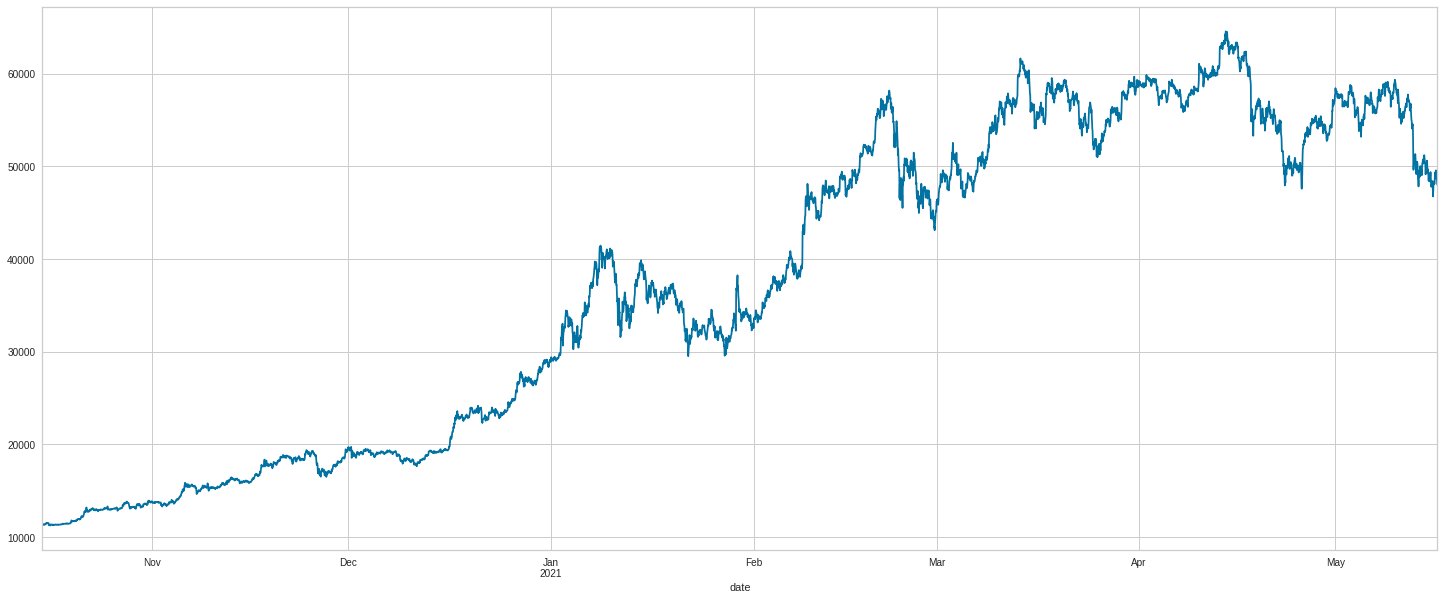

In [ ]:
df_sna.loc['BTCUSDT'].close.plot(figsize=(25,10))

#### **Alcista**

Vamos a tomar como periodo alcista el que va **desde el 01/02/2021 al 22/02/2021**

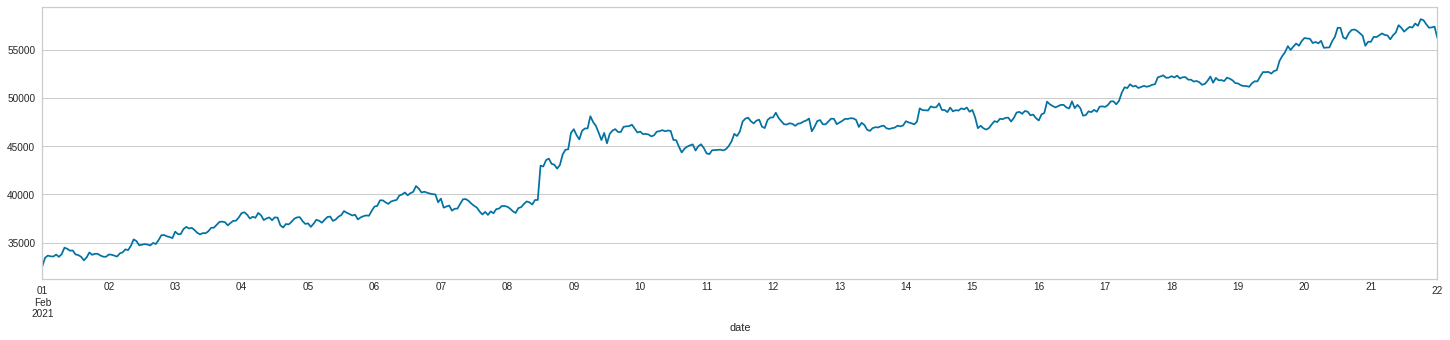

In [ ]:
df_sna.loc['BTCUSDT'].loc['2021-02-01 00:00:00':'2021-02-22 00:00:00'].close.plot(figsize=(25,5))

In [ ]:
df_estudio_alcista=df_estudio['2021-02-01 00:00:00':'2021-02-22 00:00:00']

#### **Bajista**

Vamos a tomar como periodo alcista el que va **desde el 14/04/2021 al 13/04/2021**

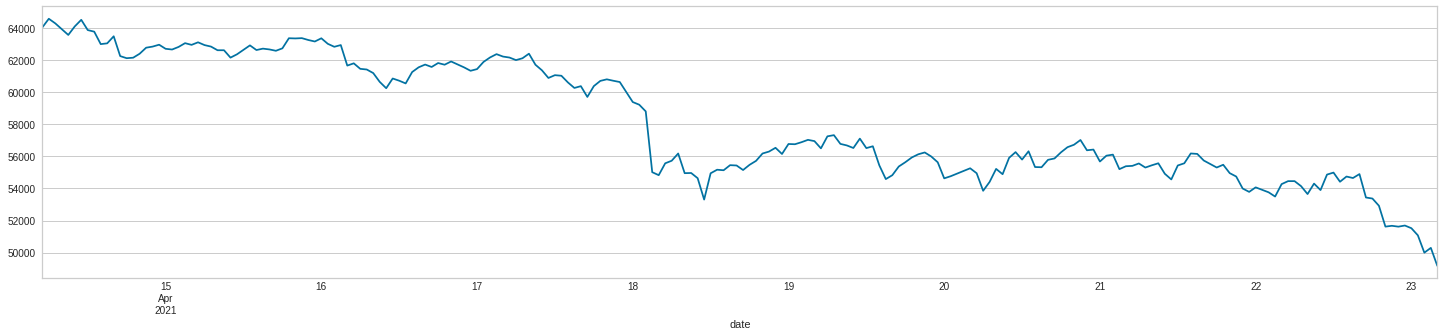

In [ ]:
df_sna.loc['BTCUSDT'].loc['2021-04-14 05:00:00':'2021-04-23 04:00:00'].close.plot(figsize=(25,5))

In [ ]:
df_estudio_bajista=df_estudio.loc['2021-04-14 05:00:00':'2021-04-23 04:00:00']

#### **Periodo mixto**
Vamos a tomar como periodo alcista el que va **desde el 01/03/2021 al 16/05/2021**

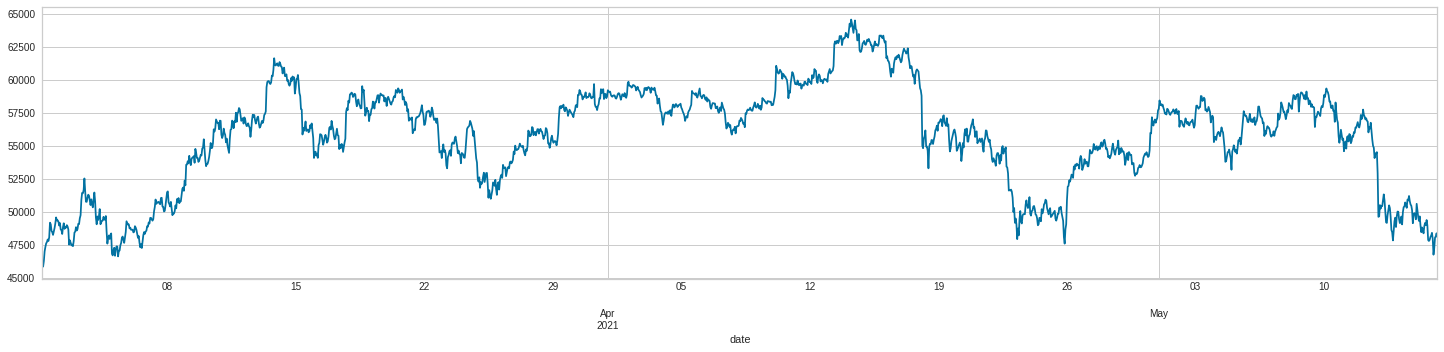

In [ ]:
df_sna.loc['BTCUSDT'].loc['2021-03-01 05:00:00':'2021-05-16 04:00:00'].close.plot(figsize=(25,5))

In [ ]:
df_estudio_mixto=df_estudio.loc['2021-03-01 05:00:00':'2021-05-16 04:00:00']

In [ ]:
X_alcista=df_estudio_alcista.transpose()
X_bajista=df_estudio_bajista.transpose()
X_mixto=df_estudio_mixto.transpose()
X=df_estudio.transpose()

## **Parte I - Clustering**

### **Mean Shift**

#### **Periodo Alcista**

#####**Datos sin escalar**

Vamos a probar con distintos bandwidth para buscar el que aumente el valor de silueta

In [ ]:
silueta_ms=[]
bandwith_ms=[]
for i in range(20,55,5):
  ms = MeanShift(bandwidth=i/100)
  pred=ms.fit_predict(X_alcista)
  bandwith_ms.append(i/100)
  silueta_ms.append(silhouette_score(X_alcista,pred))
  print(f'bandwidth:{i/100}, puntaje de silueta:{round(silhouette_score(X_alcista,pred),3)}')

bandwidth:0.2, puntaje de silueta:0.036
bandwidth:0.25, puntaje de silueta:0.008
bandwidth:0.3, puntaje de silueta:0.068
bandwidth:0.35, puntaje de silueta:0.113
bandwidth:0.4, puntaje de silueta:0.271
bandwidth:0.45, puntaje de silueta:0.271
bandwidth:0.5, puntaje de silueta:0.271


Gráfico de los resultados

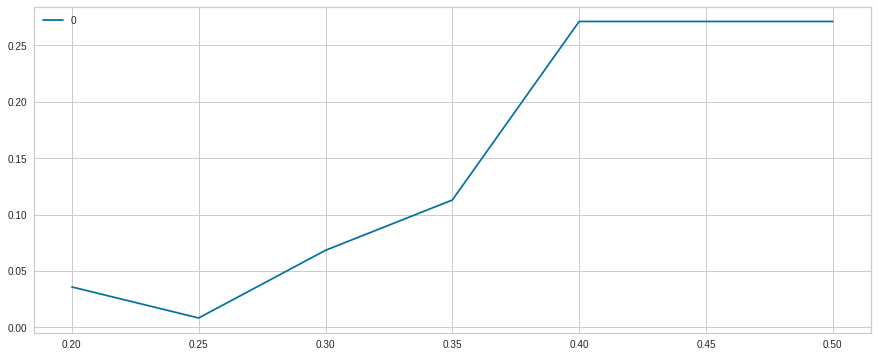

In [ ]:
  pd.DataFrame(silueta_ms,index=bandwith_ms).plot(figsize=(15,6))

Elejimos el bandwith que mejora el valor de silueta que deberia ser lo más cercano a 1 y generamos los clusters con ese bandwith

In [ ]:
ms_sin_escal = MeanShift(bandwidth=0.4)
clusters=ms_sin_escal.fit_predict(X_alcista)

In [ ]:
grupo_1=[]
grupo_2=[]
for i,coin in enumerate(coins):
  if clusters[i]==0:
    grupo_1.append(coin)
  else:
    grupo_2.append(coin)
print(f'Grupo nº1:{grupo_1}')
print(f'Grupo nº2:{grupo_2}')

Grupo nº1:['AAVEUSDT', 'ADAUSDT', 'BCHUSDT', 'BTCUSDT', 'COMPUSDT', 'DASHUSDT', 'DOTUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'LINKUSDT', 'LTCUSDT', 'MKRUSDT', 'NEOUSDT', 'XMRUSDT']
Grupo nº2:['BNBUSDT']


Se diferencia una moneda del resto

##### **Escalando los datos**
Vamos a realizar el mismo analisis en el mismo periodo pero con datos escalados

In [ ]:
silueta_ms=[]
bandwith_ms=[]
for i in range(15,35,5):
  ms = MeanShift(bandwidth=i)
  x_escal=StandardScaler().fit_transform(X_alcista)
  pred=ms.fit_predict(x_escal)
  try:
    print(f'bandwidth:{i}, puntaje de silueta:{round(silhouette_score(x_escal,pred),3)}')
    bandwith_ms.append(i)
    silueta_ms.append(silhouette_score(x_escal,pred))
  except:
    print(f'bandwidth:{i} con error')  

bandwidth:15, puntaje de silueta:0.014
bandwidth:20, puntaje de silueta:0.035
bandwidth:25, puntaje de silueta:0.08
bandwidth:30, puntaje de silueta:0.251


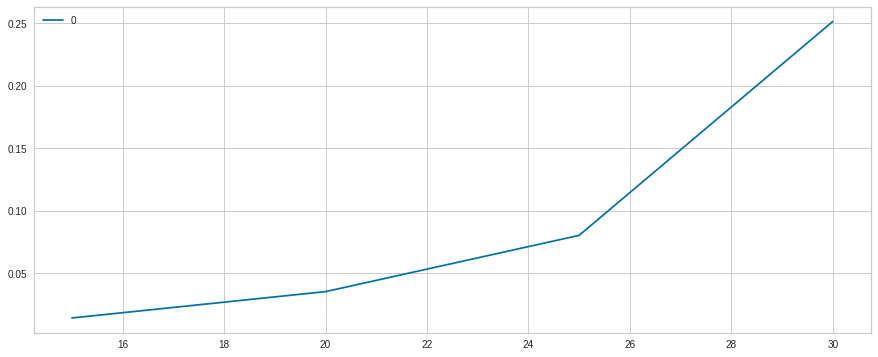

In [ ]:
pd.DataFrame(silueta_ms,index=bandwith_ms).plot(figsize=(15,6))

In [ ]:
ms_escal = MeanShift(bandwidth=30)
x_scal=StandardScaler().fit_transform(X_alcista)
clusters=ms_escal.fit_predict(x_scal)

In [ ]:
grupo_1=[]
grupo_2=[]
for i,coin in enumerate(coins):
  if clusters[i]==0:
    grupo_1.append(coin)
  else:
    grupo_2.append(coin)
print(f'Grupo nº1:{grupo_1}')
print(f'Grupo nº2:{grupo_2}')

Grupo nº1:['AAVEUSDT', 'ADAUSDT', 'BCHUSDT', 'BTCUSDT', 'COMPUSDT', 'DASHUSDT', 'DOTUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'LINKUSDT', 'LTCUSDT', 'MKRUSDT', 'NEOUSDT', 'XMRUSDT']
Grupo nº2:['BNBUSDT']


El escalado no hizo diferencia se vuelve a diferenciar la misma moneda

**Grafico de los rendimientos superpuestos**

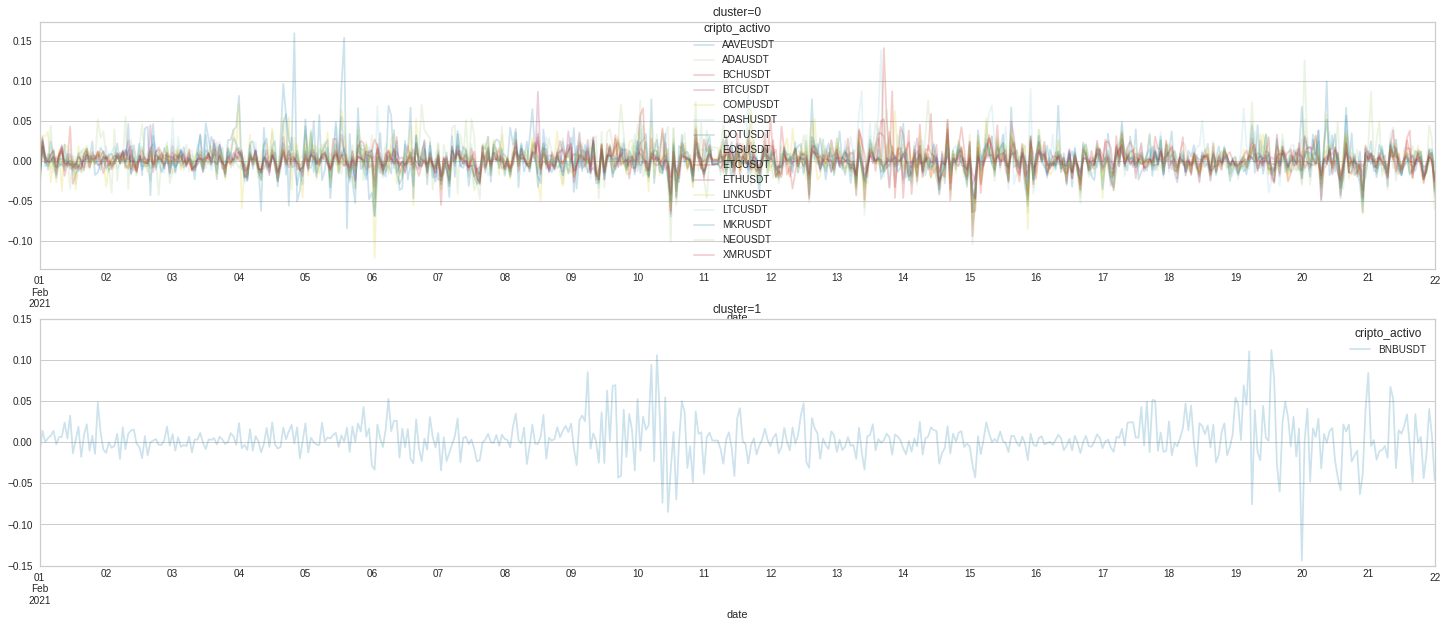

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(25,10))
for i in range(0,2):
  df_class=df_estudio_alcista.loc[:,ms_escal.labels_==i]
  df_class.plot(figsize=(25,10), alpha=.2,ax=ax[i])
  plt.ylim(-0.15,0.15)
  ax[i].title.set_text(f'cluster={i}')

En el gráfico se observa ciertos periodos con bastante diferencia conel resto de las monedas

#### **Periodo bajista escalado**

In [ ]:
for i in range(10,25,5):
  ms = MeanShift(bandwidth=i)
  x_scal=StandardScaler().fit_transform(X_bajista)
  pred=ms.fit_predict(x_scal)
  print(f'bandwidth:{i}, puntaje de silueta:{round(silhouette_score(x_scal,pred),3)}')

bandwidth:10, puntaje de silueta:0.014
bandwidth:15, puntaje de silueta:0.045
bandwidth:20, puntaje de silueta:0.191


In [ ]:
ms_escal_baj = MeanShift(bandwidth=20)
x_scal=StandardScaler().fit_transform(X_bajista)
ms_escal_baj.fit_predict(x_scal)
clases=np.unique(ms_escal_baj.fit_predict(x_scal))

**Grafico rendimientos**

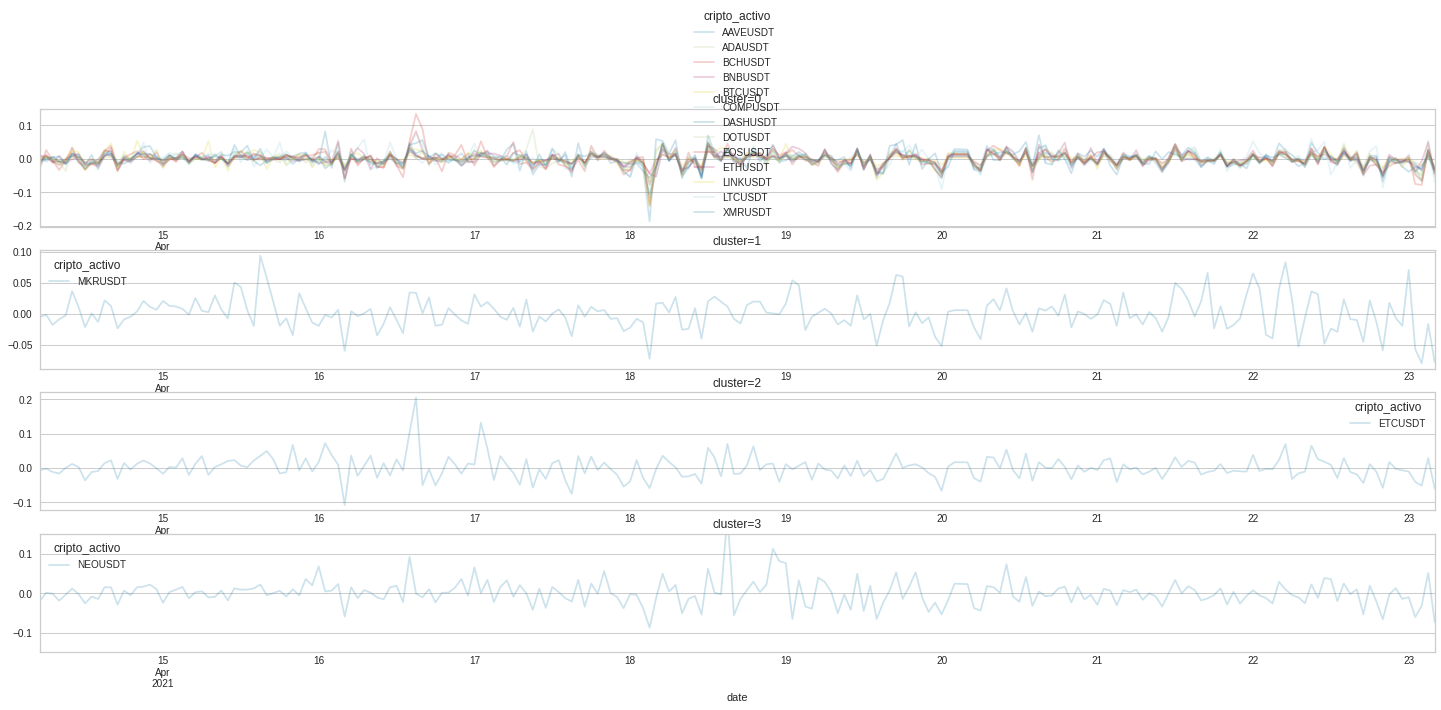

In [ ]:
fig, ax = plt.subplots(len(clases),1,figsize=(25,10))
for i in range(0,len(clases)):
  df_class=df_estudio_bajista.loc[:,ms_escal_baj.labels_==i]
  df_class.plot(figsize=(25,10), alpha=.2,ax=ax[i])
  plt.ylim(-0.15,0.15)
  ax[i].title.set_text(f'cluster={i}')

En el periodo bajista se observa que se agrupan las monedas en un grupo muy grande y en otros 3 pequeños de una moneda cada uno

#### **Periodo mixto escalado**

In [ ]:
silueta_ms=[]
bandwith_ms=[]
X_mixto_scal=StandardScaler().fit_transform(X_mixto)
for i in range(40,60,5):
  ms = MeanShift(bandwidth=i)
  pred=ms.fit_predict(X_mixto_scal)
  bandwith_ms.append(i)
  try:
    score=silhouette_score(X_mixto_scal,pred)
    silueta_ms.append(score)
    print(f'bandwidth:{i}, puntaje de silueta:{round(score,3)}')
  except:
    print(f'bandwidth:{i} con error')

bandwidth:40, puntaje de silueta:0.014
bandwidth:45, puntaje de silueta:0.034
bandwidth:50, puntaje de silueta:0.058
bandwidth:55, puntaje de silueta:0.094


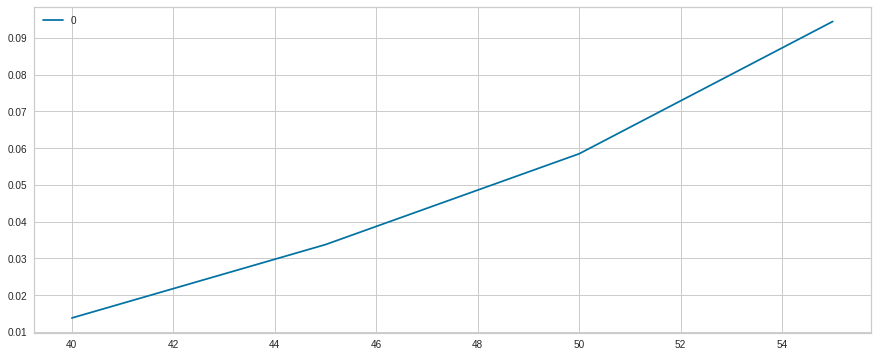

In [ ]:
pd.DataFrame(silueta_ms,index=bandwith_ms).plot(figsize=(15,6))

In [ ]:
ms_mixto = MeanShift(bandwidth=55)

ms_mixto.fit_predict(X_mixto_scal)
clases=np.unique(ms_mixto.fit_predict(X_mixto_scal))

**Grafico rendimientos**

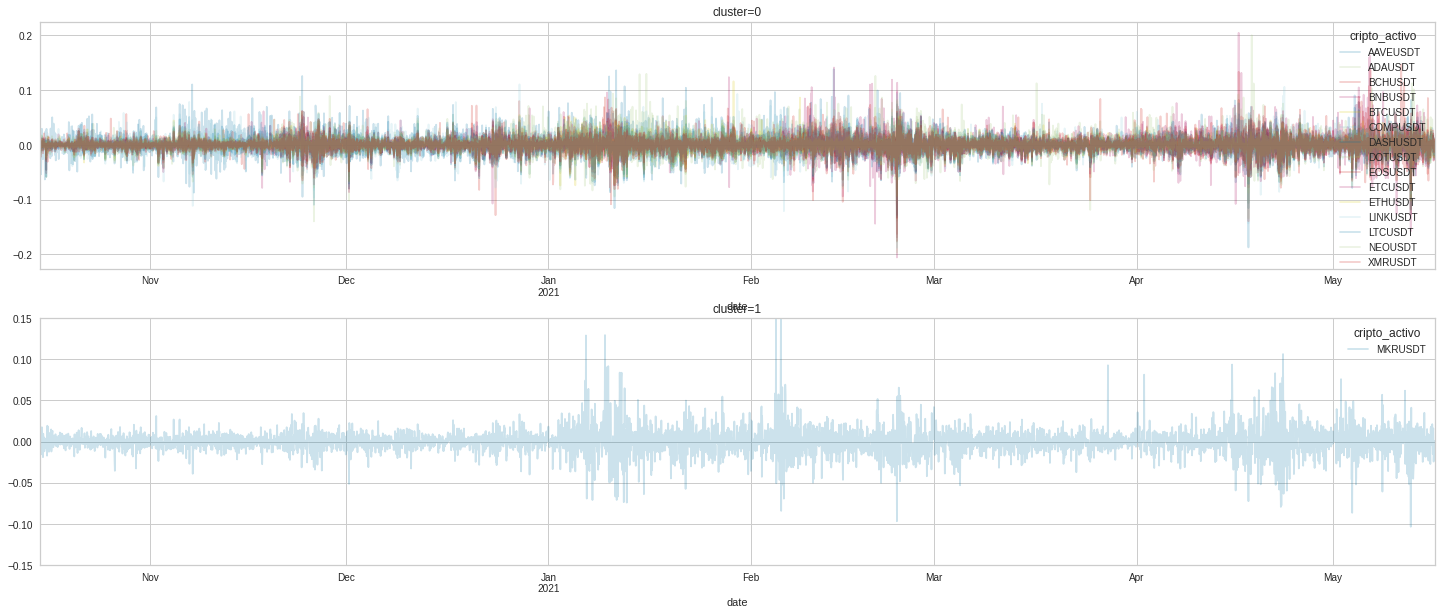

In [ ]:
fig, ax = plt.subplots(len(clases),1,figsize=(25,10))
for i in range(0,len(clases)):
  df_class=df_estudio.loc[:,ms_mixto.labels_==i]
  df_class.plot(figsize=(25,10), alpha=.2,ax=ax[i])
  plt.ylim(-0.15,0.15)
  ax[i].title.set_text(f'cluster={i}')

En el periodo mixto se separa **MKRUSDT**

### **k-means**

#### **Sin Escalar**

**Periodo alcista**

Para alimentar la funcion de kmeans es necesario trasnponer el DataFrame, para que tome que son 16 series de 500 datos y no 500 series de 16 datos

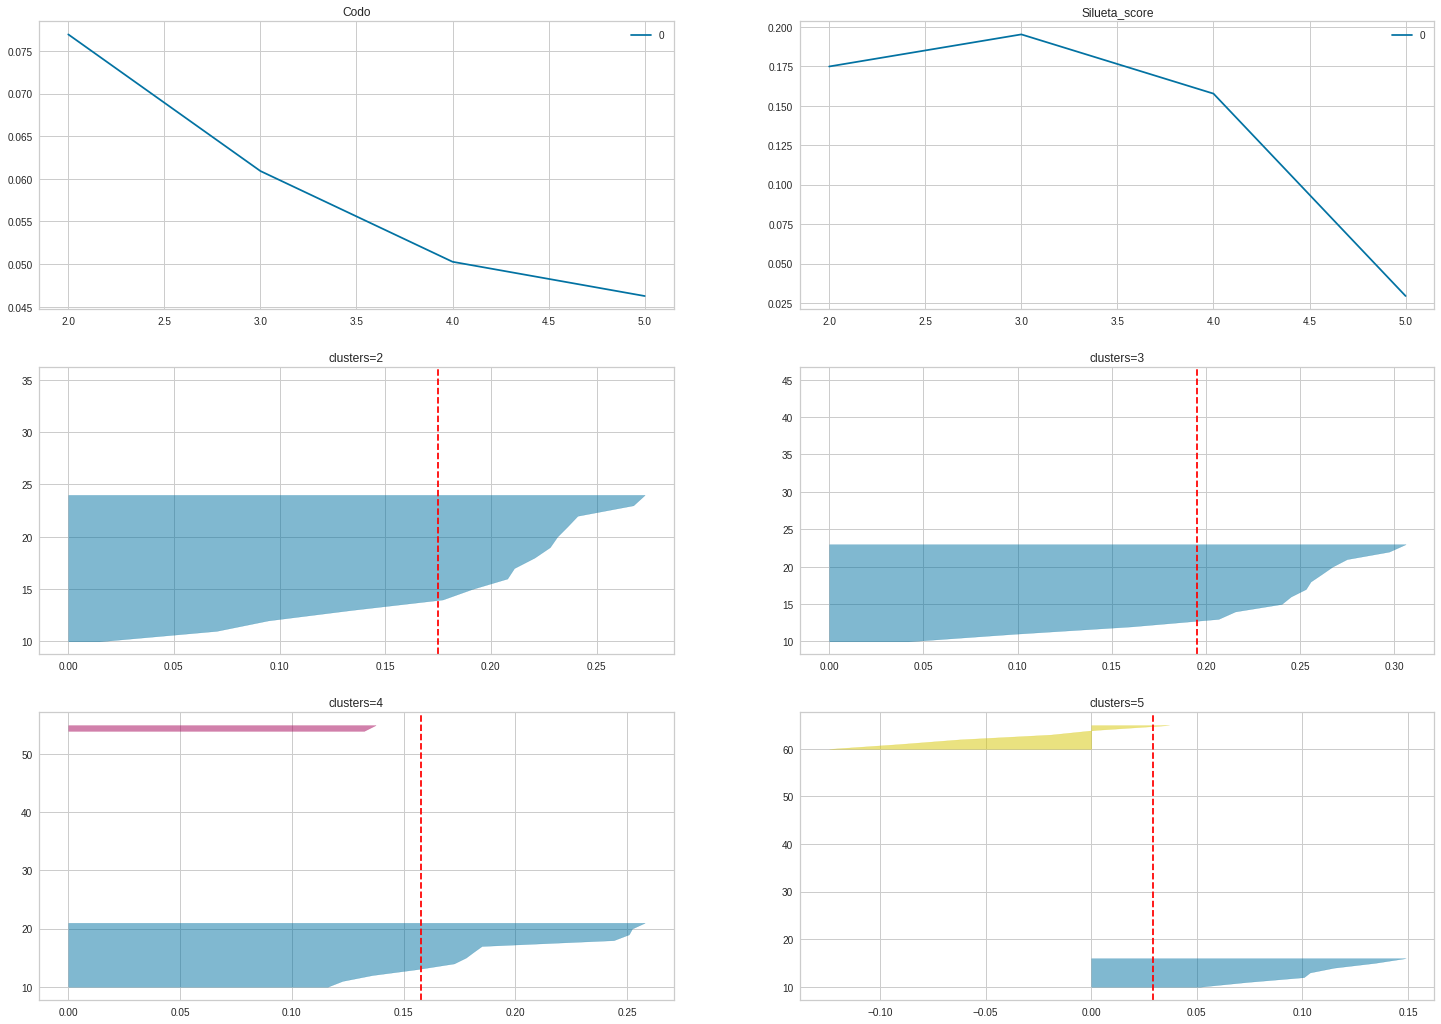

In [ ]:
kmeans_time_series(df_estudio_alcista.transpose(),iter=5,clusters_max=6,metric='euclidean')

Al formar grupos con monedas individuales no se aprecia el grafico de la silueta.

**Periodo Bajista**

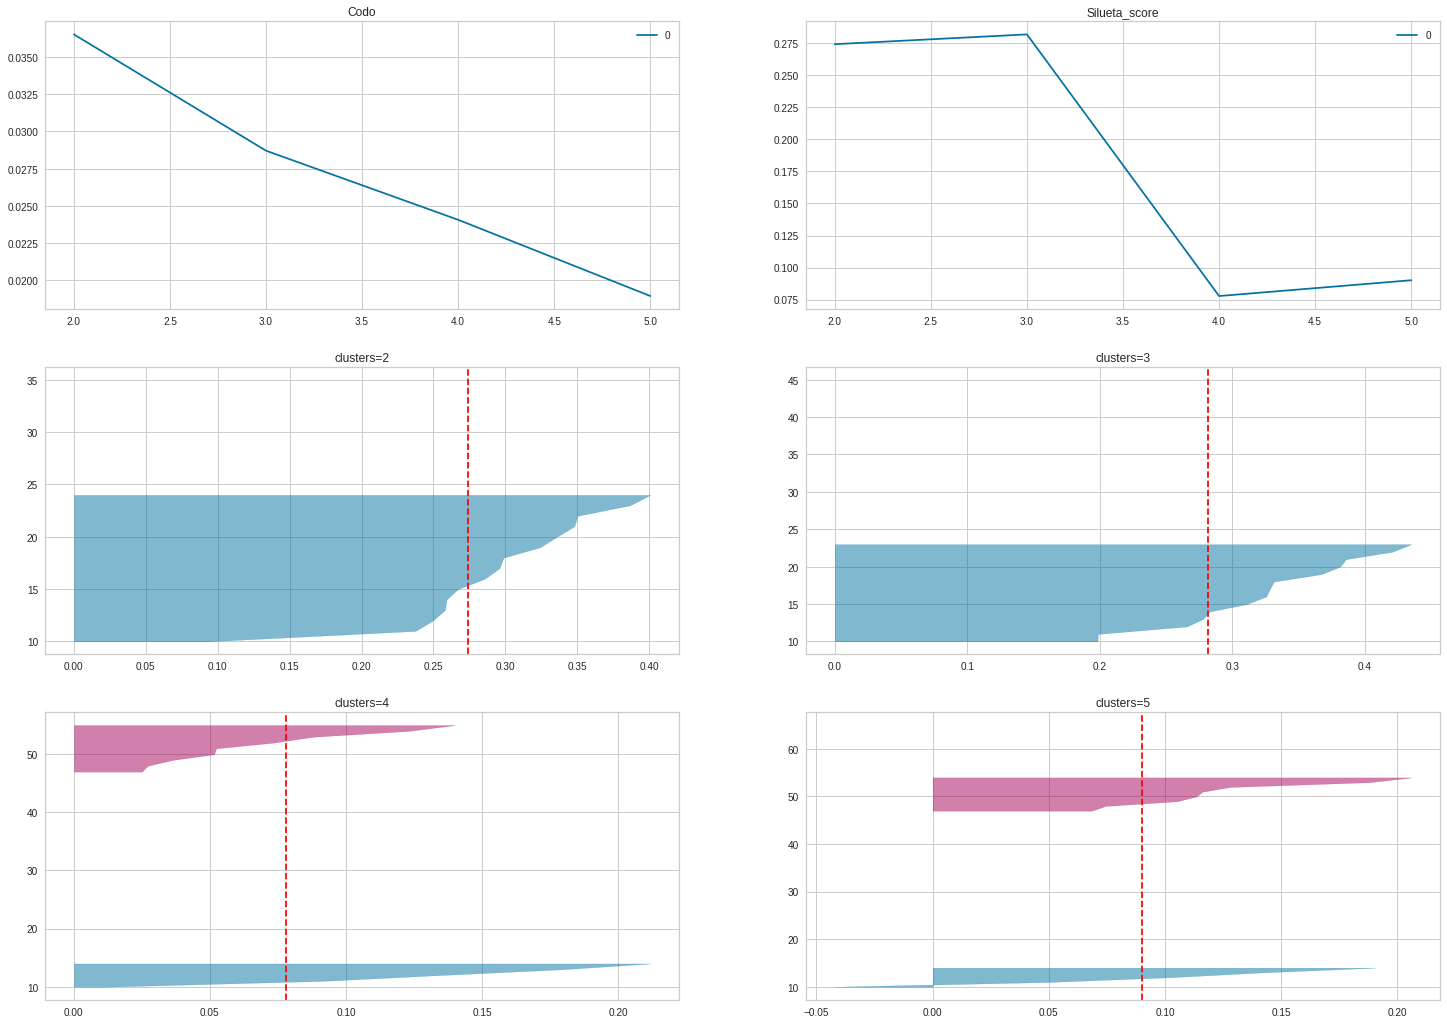

In [ ]:
kmeans_time_series(df_estudio_bajista.transpose(),iter=5,clusters_max=6,metric='euclidean')

Observando el grafico del "CODO", vemos que el mejor k es 3

Viendo el grafico de silueta_score se ve que el la cantidad de clusters es 3


Observando la visualizacion de las siluetas se observa que agrupa muchos activos en el cluster 0 y pocos o uno en los otros.

#### **Escalando**

**Periodo alcista**

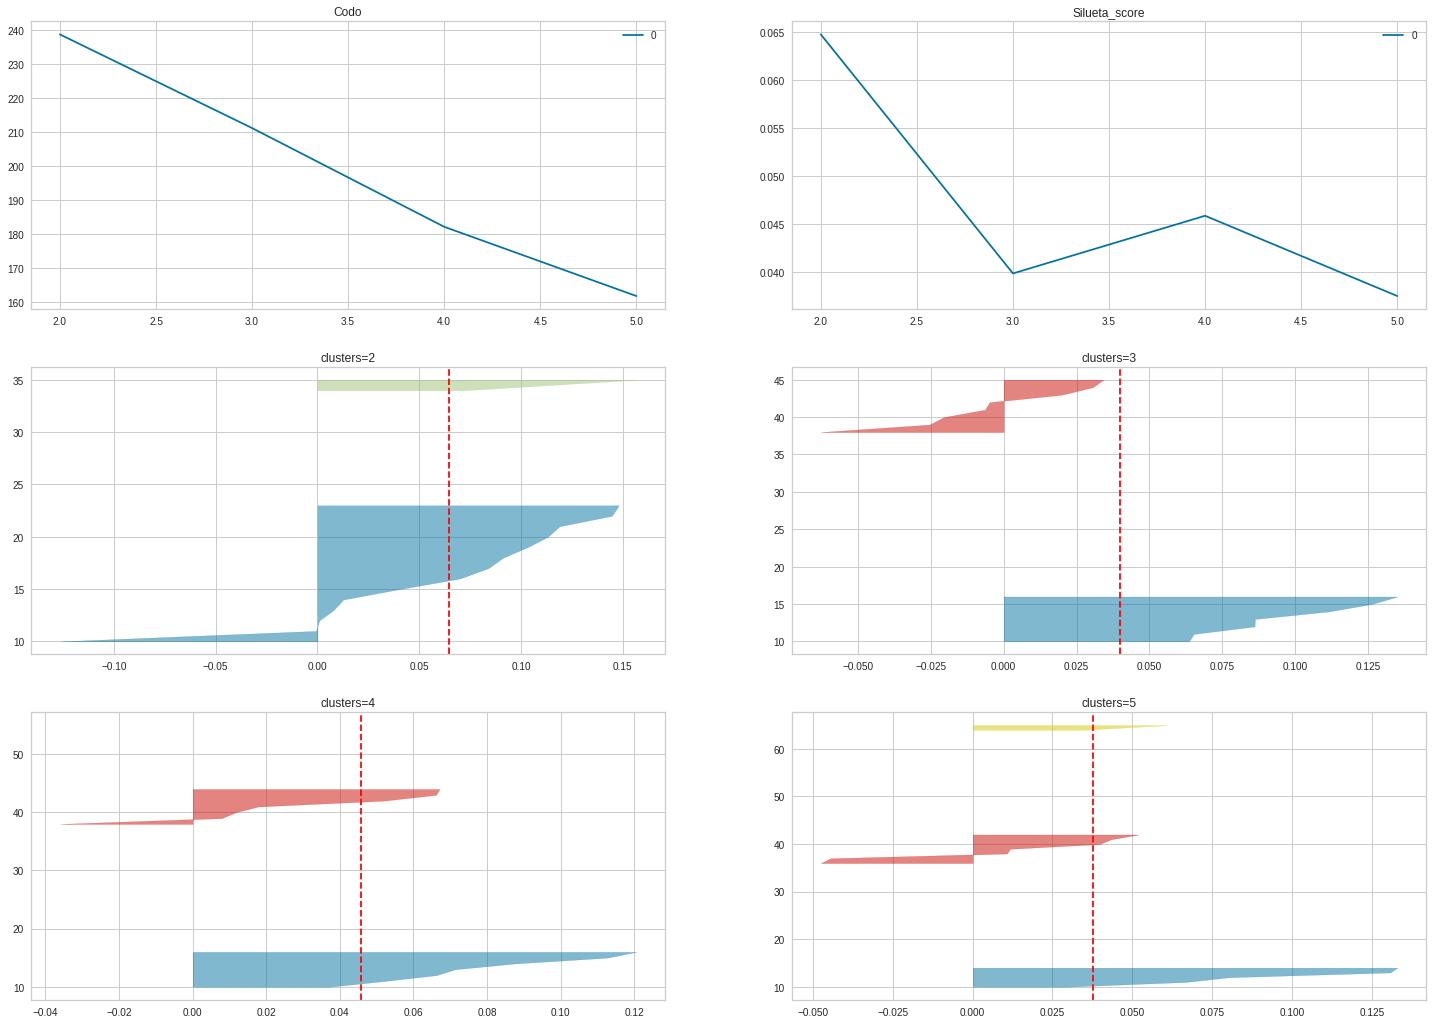

In [ ]:
kmeans_time_series(StandardScaler().fit_transform(df_estudio_alcista).transpose(),iter=10,clusters_max=6,metric='euclidean')

**Periodo bajista**

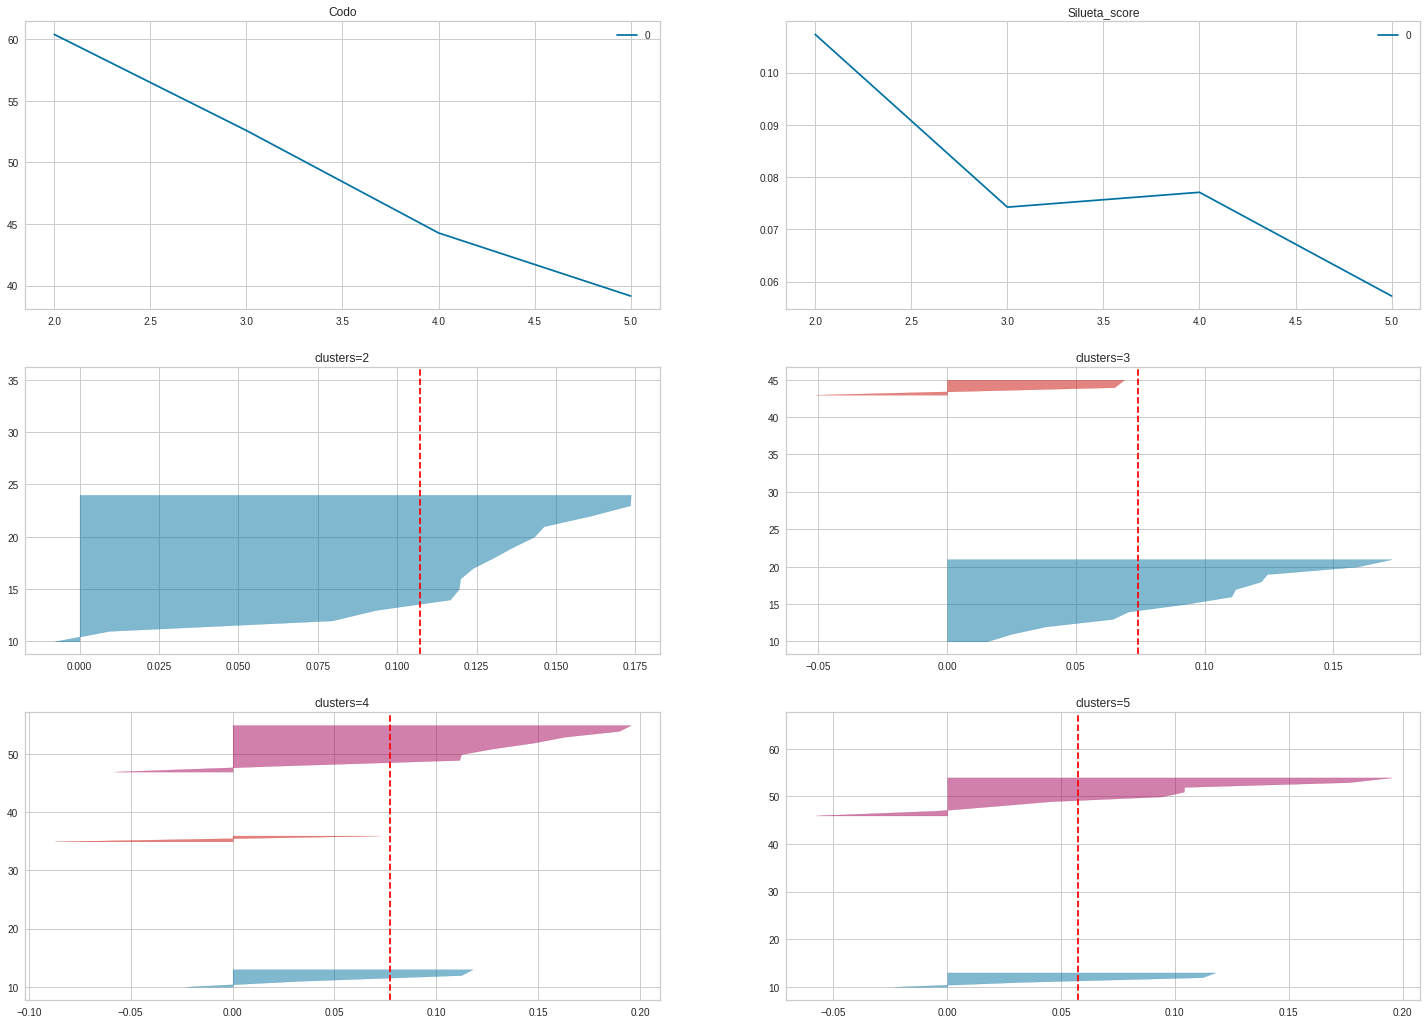

In [ ]:
kmeans_time_series(StandardScaler().fit_transform(df_estudio_bajista).transpose(),iter=5,clusters_max=6,metric='euclidean')

Al observar los graficos al estar escalados mejora la separación, pero aun deja que desear

**Grafico de Clusters**

In [ ]:
km_sin_escalar_alcista=TimeSeriesKMeans(n_clusters=4, metric='euclidean', max_iter=5,random_state=0).fit(X_alcista)
km_sin_escalar_bajista=TimeSeriesKMeans(n_clusters=4, metric='euclidean', max_iter=5,random_state=0).fit(X_bajista)

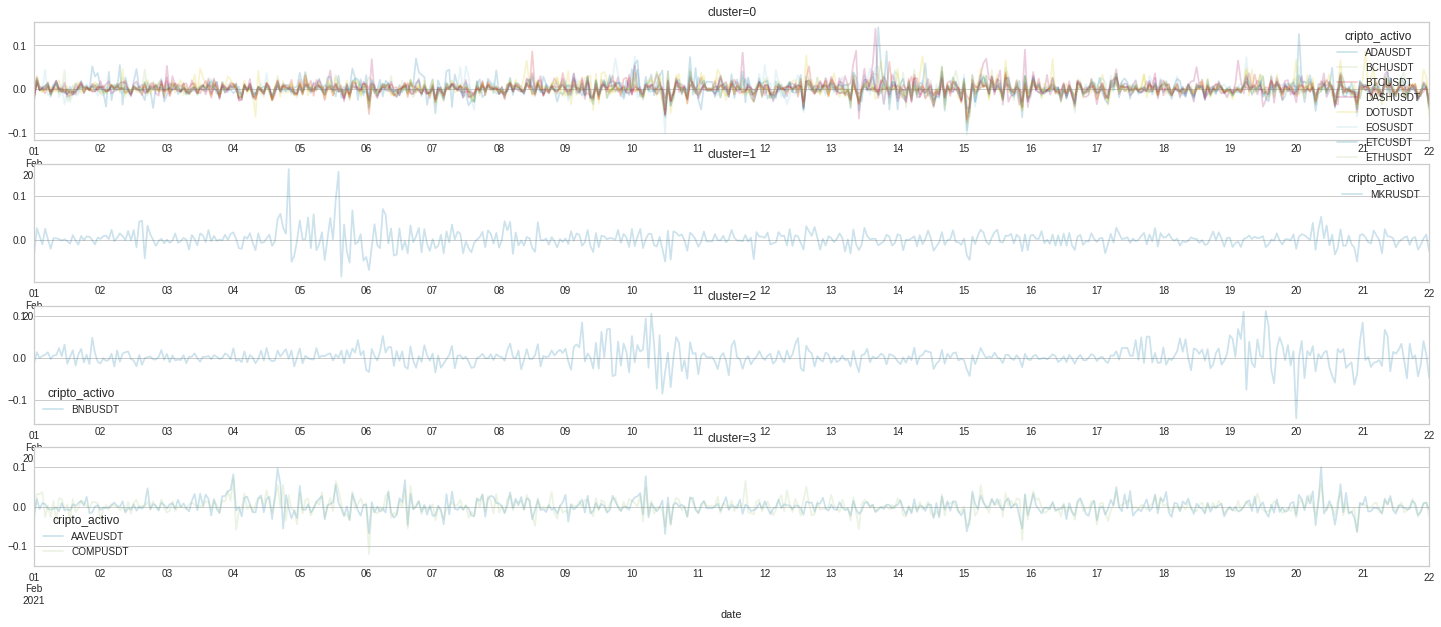

In [ ]:
  fig, ax = plt.subplots(4,1,figsize=(25,10))

  for i in range(0,4):
    #Definimos el TimeSeriesKMeans
    df_class=df_estudio_alcista.loc[:,km_sin_escalar_alcista.labels_==i]
    df_class.plot(figsize=(25,10), alpha=.2,ax=ax[i])
    plt.ylim(-0.15,0.15)
    ax[i].title.set_text(f'cluster={i}')

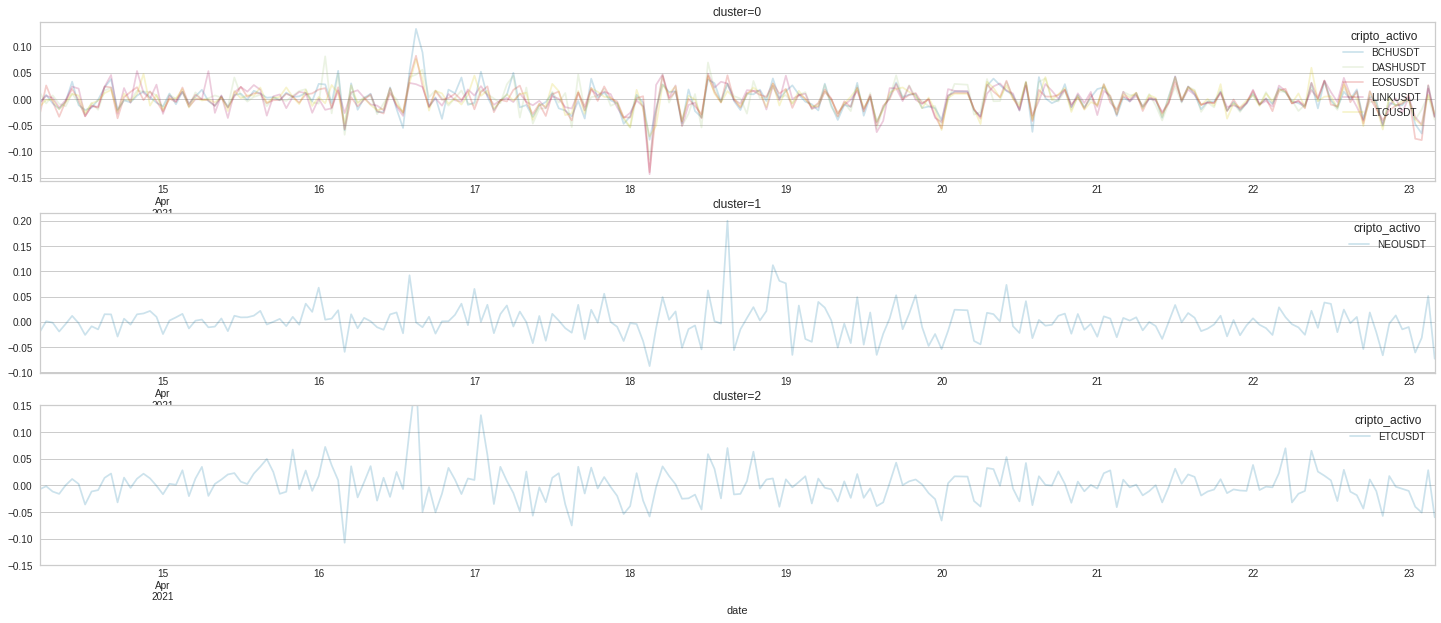

In [ ]:
  fig, ax = plt.subplots(3,1,figsize=(25,10))

  for i in range(0,3):
    #Definimos el TimeSeriesKMeans
    df_class=df_estudio_bajista.loc[:,km_sin_escalar_bajista.labels_==i]
    df_class.plot(figsize=(25,10), alpha=.2,ax=ax[i])
    plt.ylim(-0.15,0.15)
    ax[i].title.set_text(f'cluster={i}')

En el periodo alcista vuelven a ser separados el **"MKRUSDT"** y **"BNBUSDT"**

En el periodo bajista vuelven a ser separados el **"NEOUSDT"** y **"ETCUSDT"**.

Pero ningun cripto es separado en ambos casos

**Probando Metrica softdtw**

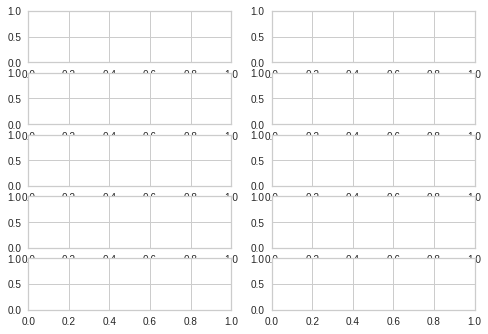

In [ ]:
  from tslearn.metrics import soft_dtw
  #soft_dtw_score = soft_dtw(x, y, gamma=.1)
  
  
  clusters_max=10
  inercia=[]
  softdtw_score=[]
  #Definicion de Subplots para graficar 
  fig, ax = plt.subplots(int(clusters_max/2),2)

  for i in range(2,clusters_max):
    #Definimos el TimeSeriesKMeans
    km = TimeSeriesKMeans(n_clusters=i, metric='softdtw', max_iter=5,random_state=0)
    km.fit(df_estudio_bajista.transpose())
    #Agrega Resultados a las listas para graficarlas
    #silueta.append(silhouette_score(data, km.fit(data).labels_, metric=metric))
    inercia.append(km.inertia_)
    #softdtw_score.append(soft_dtw(df_estudio_bajista.transpose(), km.labels_.transpose(), gamma=.1))
    q, mod = divmod(i, 2)

    #Visulizador de Silueta
    #visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    #visualizer.fit(df_estudio_bajista.transpose())
    #ax[q][mod].title.set_text(f'clusters={i}')

In [ ]:
  pd.DataFrame(inercia,index=range(2,clusters_max)).plot(figsize=(25,6*int(clusters_max/2)),ax=ax[0][0])
  ax[0][0].title.set_text('Codo')

###**Clustering jeráquico**
https://towardsdatascience.com/how-to-apply-hierarchical-clustering-to-time-series-a5fe2a7d8447

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [ ]:
!pip install sktime

     |████████████████████████████████| 6.1 MB 2.6 MB/s 
     |████████████████████████████████| 23.2 MB 1.5 MB/s 
     |████████████████████████████████| 9.8 MB 53.5 MB/s 
     |████████████████████████████████| 3.3 MB 49.5 MB/s 
     |████████████████████████████████| 26.3 MB 93 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.8.1 requires stat

####**Periodo Alcista**

##### **Construcción de la matriz de distancias**

In [ ]:
# Si se quiere usar como metrica de distancia la matriz de correlacion
# Simplemente se saca la correlacion entre los pares de series como matriz de distancia
# Las series tienen que tener la misma longitud
# Las Series tienen que estar en fase, es decir alineadas en el tiempo

# Los datos tienen que ser de la forma en la que cada serie es una columna, es decir una columna por moneda
distance_matrix_corr = df_estudio_alcista.corr()


In [ ]:
# Si se quiere utilizar la distancia como metrica de distancia: Dynamic Time Warping. 
#DTW es una tecnica para medir similaridad entre dos sequencias temporales que no estan exacatamwente alineadas en el tiempo, velocidad o longitud

#  Series pueden tener distintas longitudes
#  Series pueden no estar alineadas en el tiempo

from sktime.distances.elastic_cython import dtw_distance

# La función dtw_distance espera series con la forma (l, m) array, 
# donde l=longitud de las series, m=# dimensiones (en este caso l=505,m=1)

series_list = list(df_estudio_alcista.transpose().values)

for i in range(len(series_list)):
    length = len(series_list[i])
    series_list[i] = series_list[i].reshape((length, -1))

# inicializar la matrix de distancias
n_series = len(series_list)
distance_matrix_dtw = np.zeros(shape=(n_series, n_series))

# Construcción de la matrix de distancias
for i in range(n_series):
    for j in range(n_series):
        x = series_list[i]
        y = series_list[j]
        if i != j:
            dist = dtw_distance(x, y)
            distance_matrix_dtw[i, j] = dist

##### **Linkage Matrix o Matriz de vinculación**

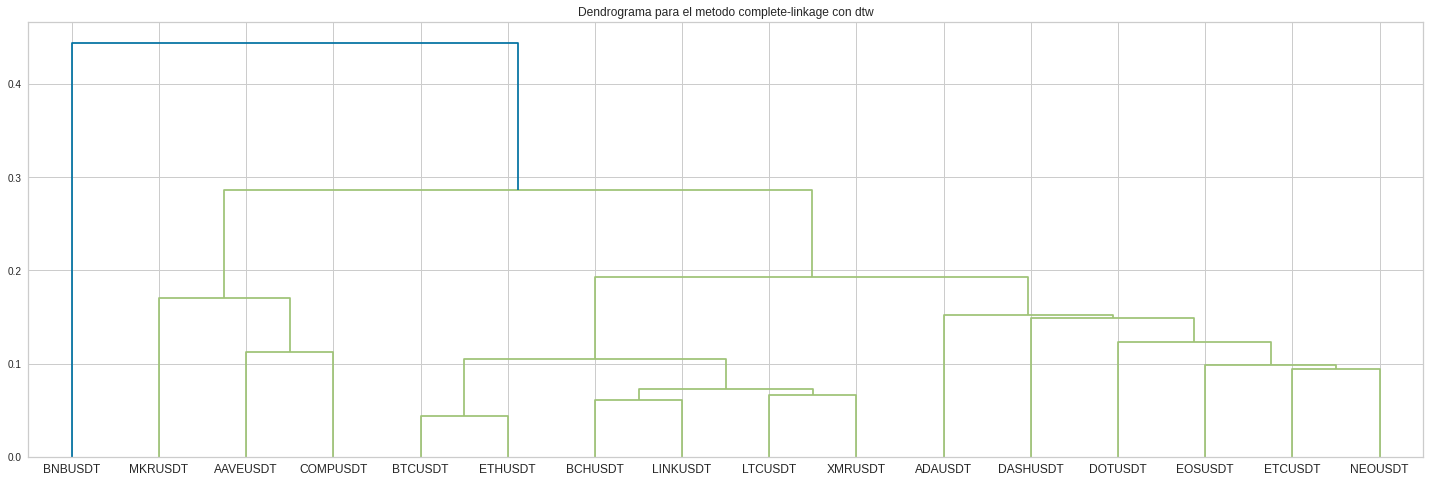

In [ ]:
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram

def hierarchical_clustering(dist_mat,tipo_distancia, method='complete'):
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)
    
    fig = plt.figure(figsize=(25, 8))
    dn = dendrogram(Z,labels=coins)
    plt.title(f"Dendrograma para el metodo {method}-linkage con {tipo_distancia}")
    plt.show()
    
    return Z

linkage_matrix_dtw = hierarchical_clustering(distance_matrix_dtw,'dtw')

En el dendograma, se puede identificar visualmente el numero de clusters
deslizando una linea horizontal de abajo hacia arriba.

Observando se ve que hay dos grupos bien diferenciados, una moneda por un lado 'BNBUSDT' y el resto por el otro lado. Bajando un poco más, con distancias más pequeñas se ve que el subgrupo del resto de las monedas se puede empezar a diferenciar.



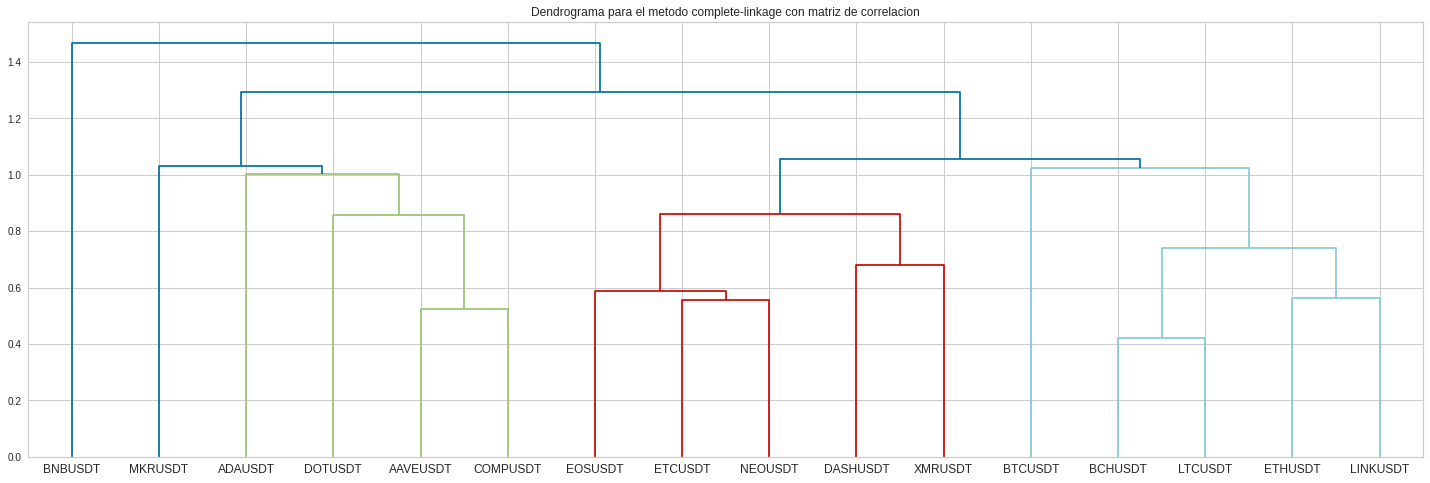

In [ ]:
linkage_matrix = hierarchical_clustering(distance_matrix_corr,'matriz de correlacion')

Observando el dendograma con la distancia de 'matriz de correlacion', se ve que hay dos grupos donde se separa una moneda, por un lado y el resto por el otro, luego se forman sub clusters en el grupo de más monedas, pero más marcados que usando DTW.

##### **Separando los Clusters**

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Seleccionando la cantidad máxima de clusters
cluster_labels = fcluster(linkage_matrix_dtw, 5, criterion='maxclust')
print(np.unique(cluster_labels))

#cluster_labels = fcluster(linkage_matrix, 10, criterion='maxclust')
#print(np.unique(cluster_labels))

# Seleccionando a mano el corte en funcion de lo visto en el dendograma
#cluster_labels = fcluster(linkage_matrix_dtw, 0.2, criterion='distance')
#print(np.unique(cluster_labels))

[1 2 3 4 5]


In [ ]:
cluster_labels

array([1, 4, 3, 5, 3, 1, 4, 4, 4, 4, 3, 3, 3, 2, 4, 3], dtype=int32)

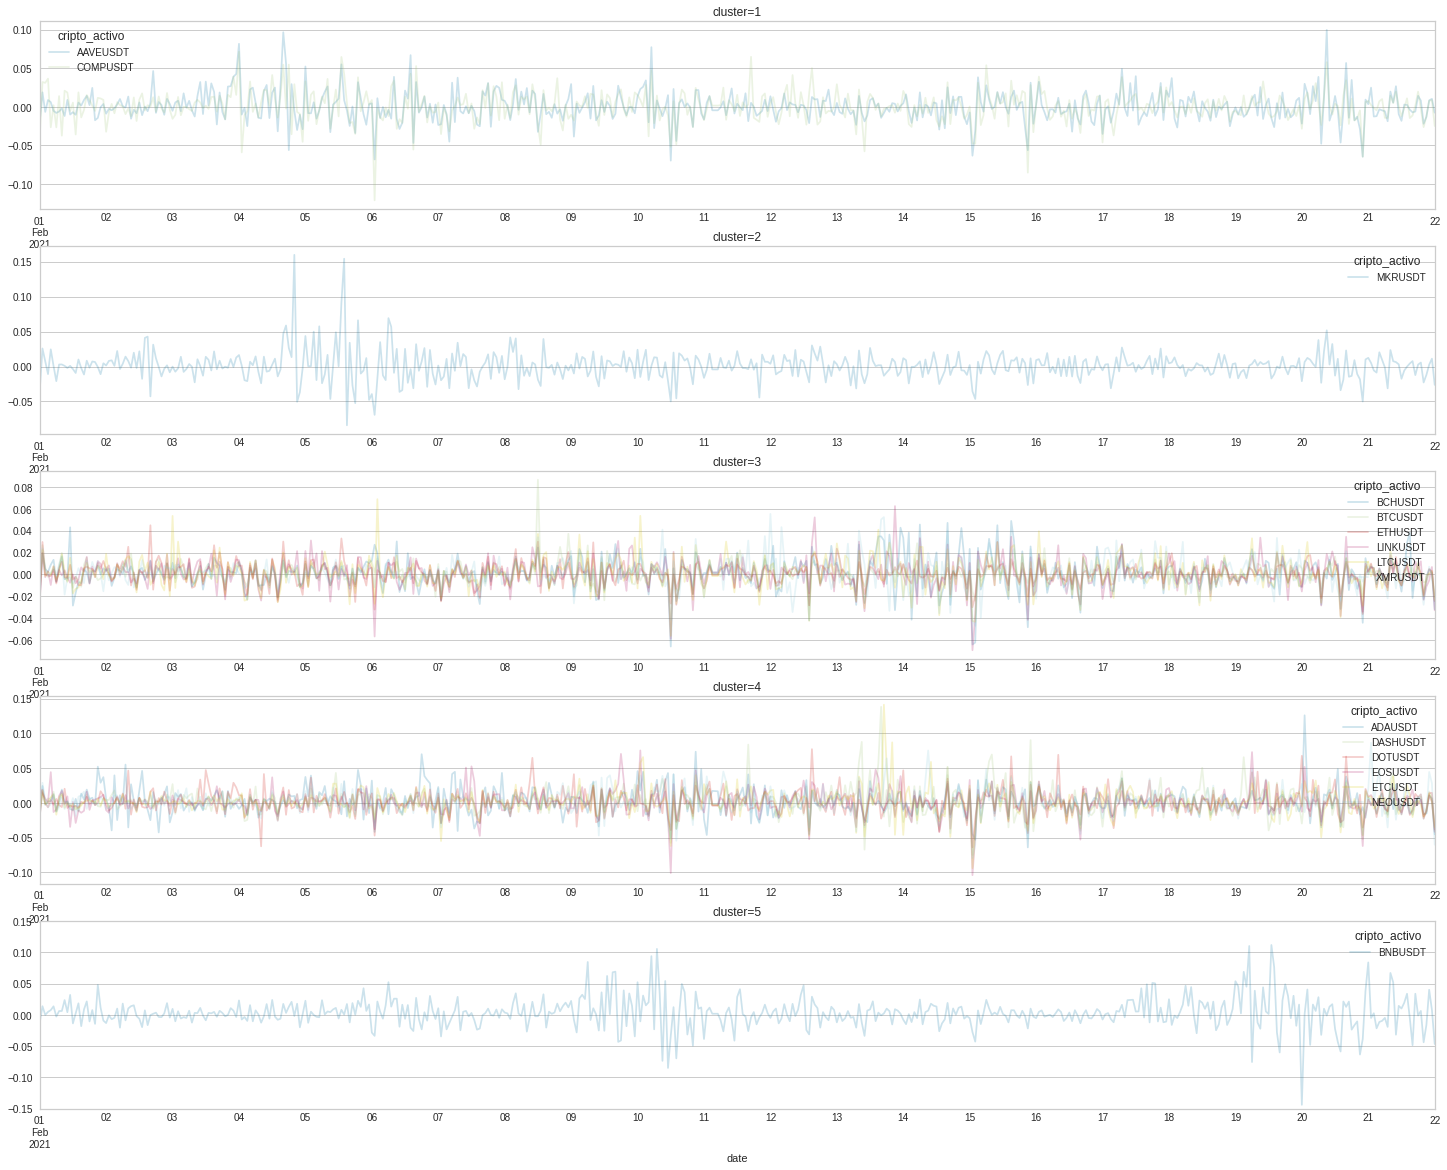

In [ ]:
fig, ax = plt.subplots(len(np.unique(cluster_labels)),1,figsize=(25,10))
for i in range(0,len(np.unique(cluster_labels))):
  df_class=df_estudio_alcista.loc[:,cluster_labels==i+1]
  df_class.plot(figsize=(25,20), alpha=.2,ax=ax[i])
  plt.ylim(-0.15,0.15)
  ax[i].title.set_text(f'cluster={i+1}')

####**Periodo Bajista**

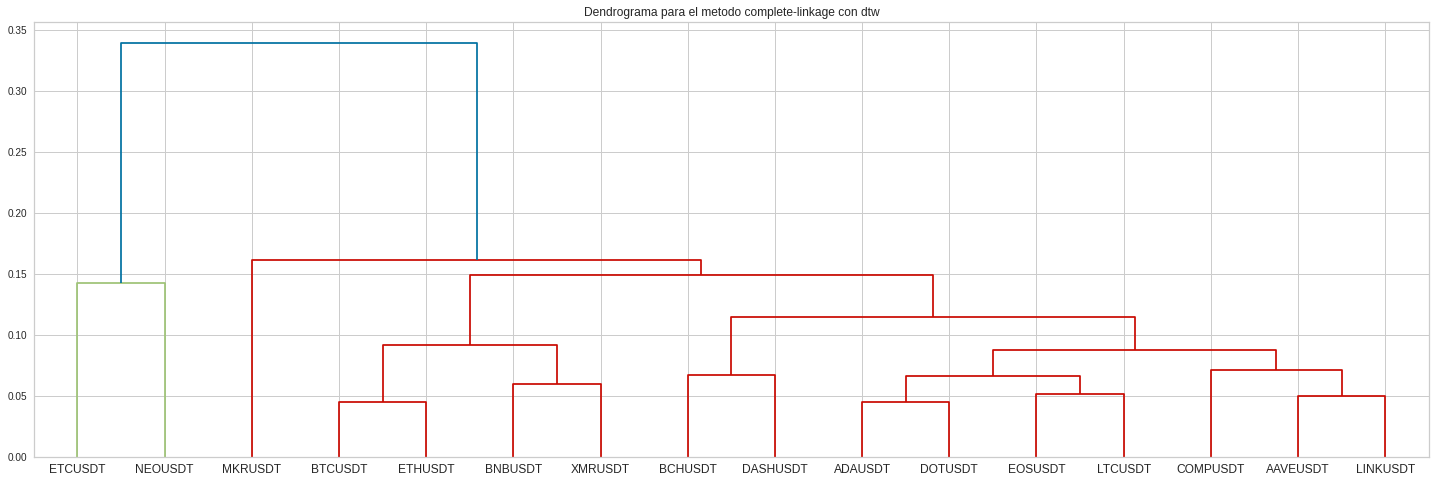

In [ ]:
series_list = list(df_estudio_bajista.transpose().values)

for i in range(len(series_list)):
    length = len(series_list[i])
    series_list[i] = series_list[i].reshape((length, -1))

# inicializar la matrix de distancias
n_series = len(series_list)
distance_matrix_dtw = np.zeros(shape=(n_series, n_series))

# Construcción de la matrix de distancias
for i in range(n_series):
    for j in range(n_series):
        x = series_list[i]
        y = series_list[j]
        if i != j:
            dist = dtw_distance(x, y)
            distance_matrix_dtw[i, j] = dist




linkage_matrix = hierarchical_clustering(distance_matrix_dtw,'dtw')

In [ ]:
cluster_labels = fcluster(linkage_matrix, 0.16, criterion='distance')
print(np.unique(cluster_labels))

[1 2 3]


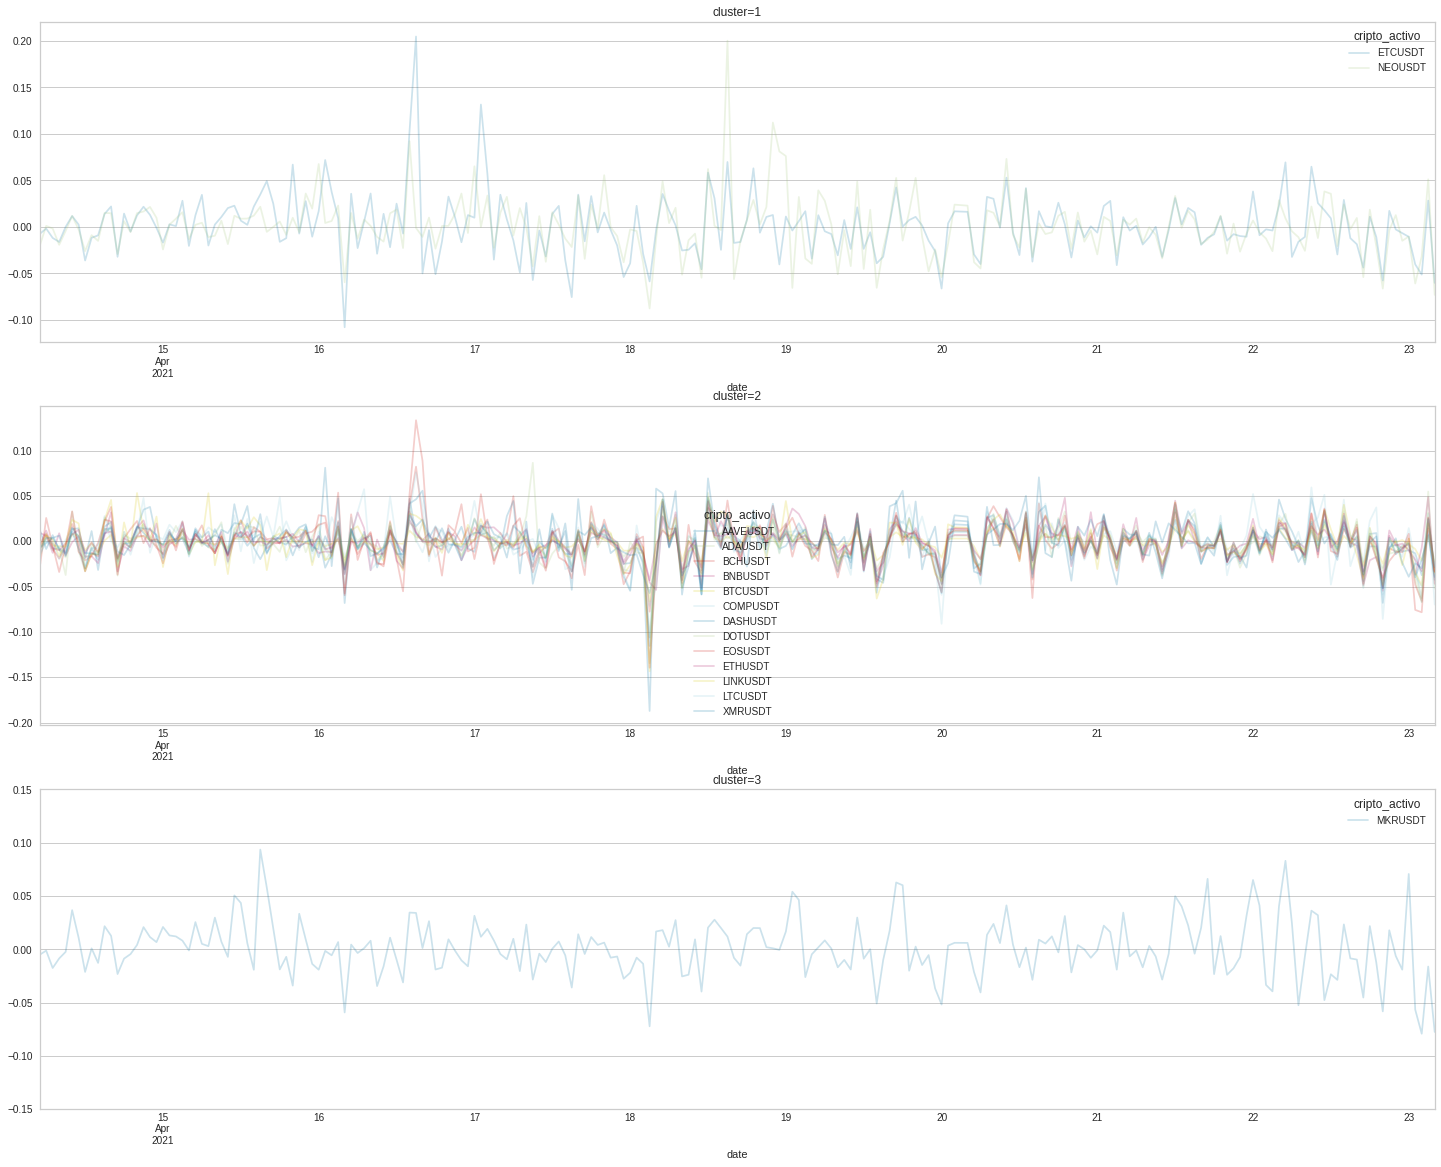

In [ ]:
fig, ax = plt.subplots(len(np.unique(cluster_labels)),1,figsize=(25,10))
for i in range(0,len(np.unique(cluster_labels))):
  df_class=df_estudio_bajista.loc[:,cluster_labels==i+1]
  df_class.plot(figsize=(25,20), alpha=.2,ax=ax[i])
  plt.ylim(-0.15,0.15)
  ax[i].title.set_text(f'cluster={i+1}')

### **Conclusión**

Se observa que:
* En el periodo alcista,el **'BNBUSDT'** es el más diferenciado del resto de las monedas, las otras 15 tuvieron comportamientos similares, buscando más clusters o menores distancias de separación aparecen otras agrupaciones. Siendo el **'MKRUSDT'** el proximo en diferenciarse.

* En el periodo bajista los primeros en diferenciarse son **'NEOUSDT'** y **'ETCUSDT'** y luego **'MKRUSDT'**

* Más allá de estas observaciones la principal conclusión es que todas las monedas tienen un comportamiento similar, al menos la mayoria del tiempo y **'MKRUSDT'** pareciera ser la que más se diferencia, tanto en alcista como bajista


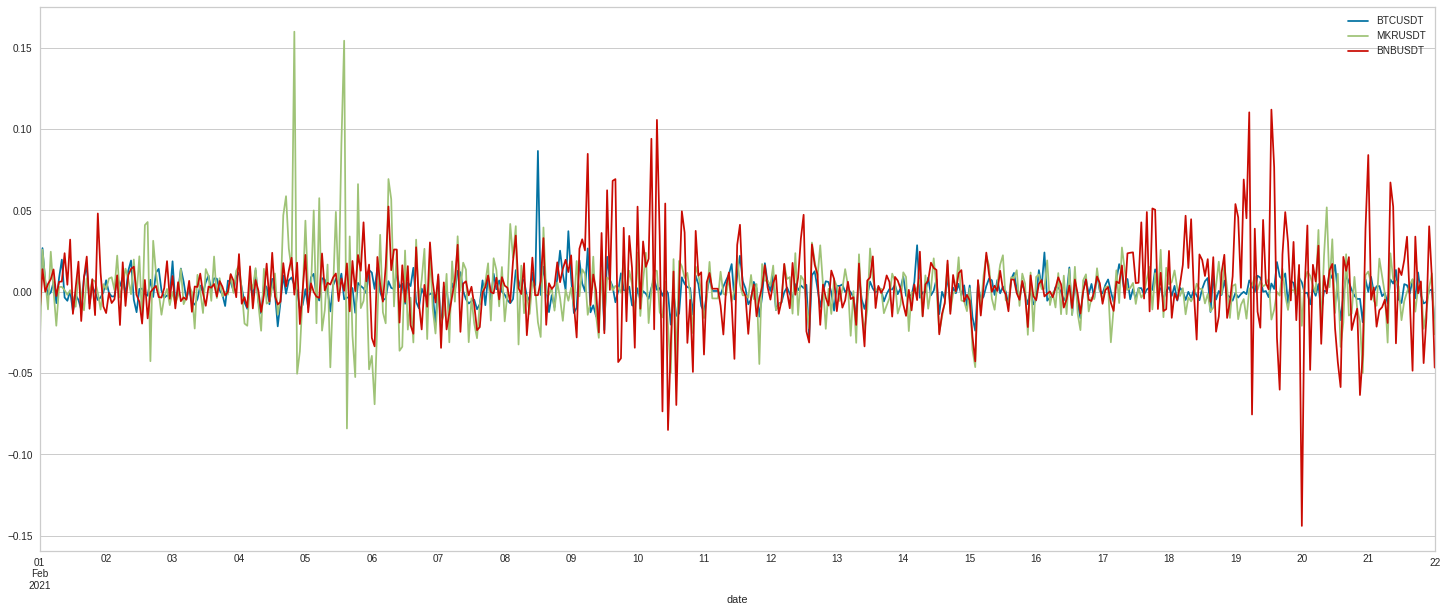

In [ ]:
pd.DataFrame(df_estudio_alcista.loc[:,('BTCUSDT','MKRUSDT','BNBUSDT')],index=df_estudio_alcista.index,columns=('BTCUSDT','MKRUSDT','BNBUSDT')).plot(figsize=(25,10))

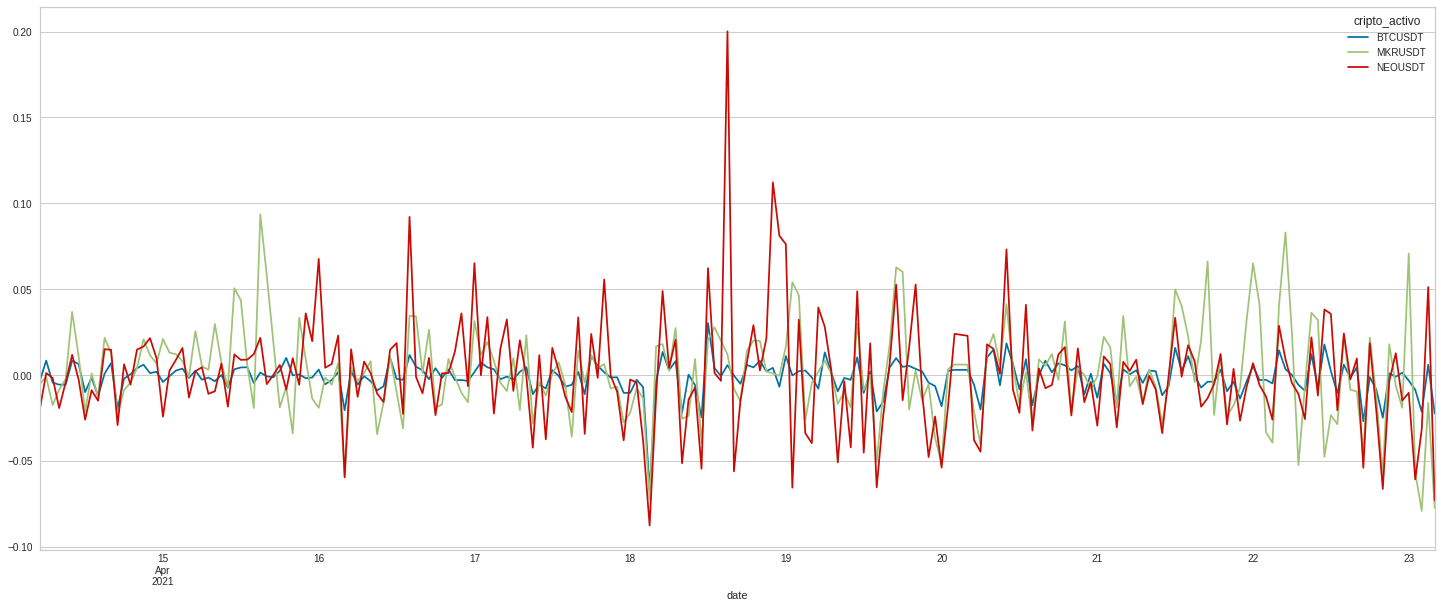

In [ ]:
df_estudio_bajista.loc[:,('BTCUSDT','MKRUSDT','NEOUSDT')].plot(figsize=(25,10))

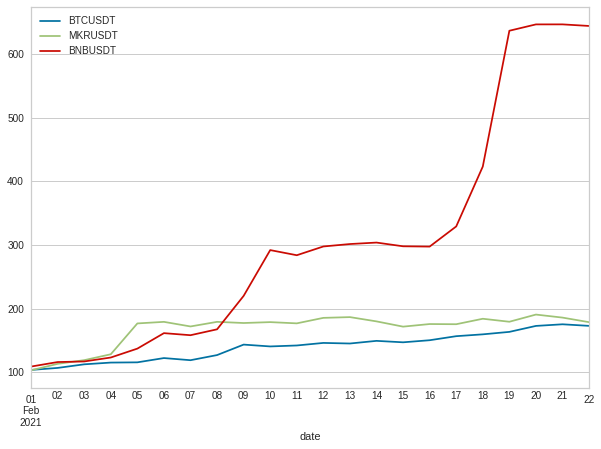

In [ ]:
# Porcentaje de variacion diario respecto al comienzo del periodo
fig, axes = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
monedas=('BTCUSDT','MKRUSDT','BNBUSDT')
for cripto in monedas:
  close_aux= df_sna.loc[cripto].loc['2021-02-01 00:00:00':'2021-02-22 00:00:00']['close']

  close_normalizado=close_aux.div(close_aux.iloc[0]).mul(100)
 
  close_normalizado=close_normalizado.resample('D').mean()
  close_normalizado.plot()
  
plt.legend(monedas)
plt.show()

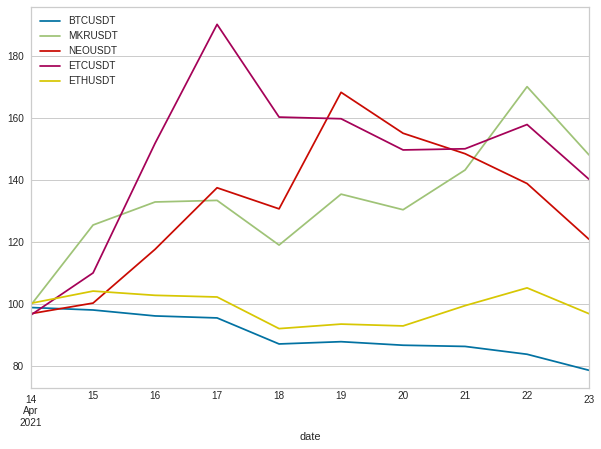

In [ ]:
# Porcentaje de variacion diario respecto al comienzo del periodo
fig, axes = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
monedas=('BTCUSDT','MKRUSDT','NEOUSDT','ETCUSDT','ETHUSDT')
for cripto in monedas:
  close_aux= df_sna.loc[cripto].loc['2021-04-14 05:00:00':'2021-04-23 04:00:00']['close']

  close_normalizado=close_aux.div(close_aux.iloc[0]).mul(100)
 
  close_normalizado=close_normalizado.resample('D').mean()
  close_normalizado.plot()
  
plt.legend(monedas)
plt.show()

## **Parte II - Embeddings**

In [ ]:
pca=PCA(n_components=16)

### **Periodo Alcista**

#### **Con datos sin Escalar**

In [ ]:
x_alc=df_estudio_alcista.transpose()

Explained variance: 
[0.0174 0.0151 0.0089 0.0084 0.0078 0.0066 0.0062 0.0045 0.0043 0.004
 0.0029 0.0023 0.002  0.0018 0.0007 0.    ]
Explained variance ratio
[0.1873 0.1624 0.0958 0.0909 0.0838 0.0713 0.0666 0.0488 0.0465 0.043
 0.0313 0.0249 0.0213 0.0191 0.007  0.    ]
11 0.9525060001230568


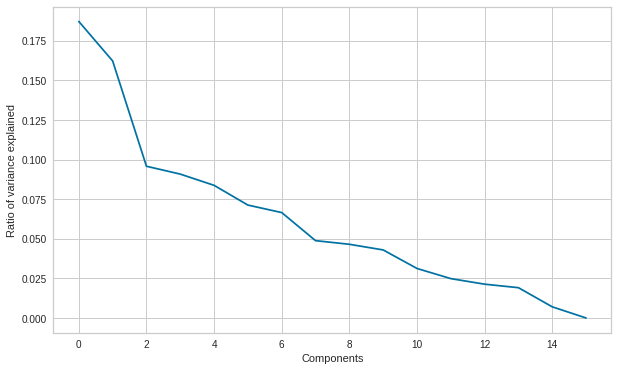

In [ ]:
pca.fit(x_alc)
#Obtenemos n componentes principales
proyected_features_alc = pca.transform(x_alc)

print("Explained variance: ")
print(pca.explained_variance_.round(4))
print("Explained variance ratio")
print(pca.explained_variance_ratio_.round(4))
  #proyected_features.shape

  #Porcentaje  de varianza para los primeros n componentes principales
fig = plt.figure(figsize=(10,6))
sns.lineplot(x=range(pca.n_components),
                  y=pca.explained_variance_ratio_,)

plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")

porcentaje=0.95
suma=0
for component in range(pca.n_components):

  suma+=pca.explained_variance_ratio_[component]
  if suma>=porcentaje:
    #print(component)
    break
print(component,suma)


12 componentes explican el 95% de la varianza y las primeras 4 componentes explican más del 50% de la varianza

In [ ]:
import plotly.graph_objs as go

In [ ]:
#Grafico

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

PCA_coins =go.Scatter(x=proyected_features_alc[:,0], y=proyected_features_alc[:,1],name='Coins',
                      text=x_alc.index,
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[1],size=7),mode='markers+text')

data=[PCA_coins]

layout = go.Layout(title="PCA",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)


In [ ]:
fig.show(renderer="colab")

#### **Con datos Escalados**

In [ ]:
x_alcista_sca=StandardScaler().fit_transform(df_estudio_alcista).transpose()

In [ ]:
x_alcista_sca.shape

(16, 505)

Explained variance: 
[43.3929 33.156  30.7327 24.0687 23.5856 19.5805 18.3345 17.1113 14.0437
 12.3866 11.8073 10.8496  9.0598  8.2916  6.6012  0.    ]
Explained variance ratio
[0.1533 0.1172 0.1086 0.085  0.0833 0.0692 0.0648 0.0605 0.0496 0.0438
 0.0417 0.0383 0.032  0.0293 0.0233 0.    ]
14 0.9766744320123826


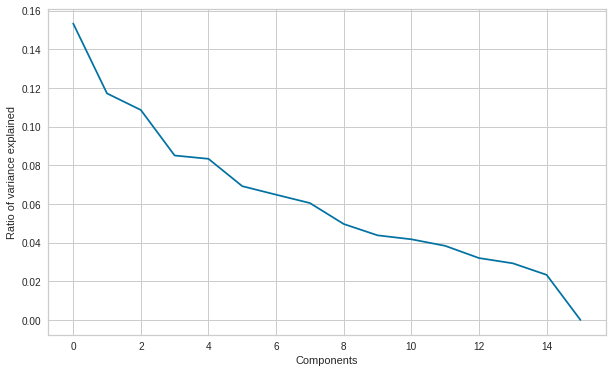

In [ ]:
pca.fit(x_alcista_sca)

#Obtenemos n componentes principales
proyected_features_alc = pca.transform(x_alcista_sca)

print("Explained variance: ")
print(pca.explained_variance_.round(4))
print("Explained variance ratio")
print(pca.explained_variance_ratio_.round(4))

  #Porcentaje  de varianza para los primeros n componentes principales
fig = plt.figure(figsize=(10,6))
sns.lineplot(x=range(pca.n_components),
                  y=pca.explained_variance_ratio_,)

plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")

porcentaje=0.95
suma=0
for component in range(pca.n_components):

  suma+=pca.explained_variance_ratio_[component]
  if suma>=porcentaje:
    #print(component)
    break
print(component+1,suma)


15 componentes explican el 95% de la varianza

In [ ]:
#Grafico

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

PCA_coins =go.Scatter(x=proyected_features_alc[:,0], y=proyected_features_alc[:,1],name='Coins',
                      text=x_alc.index,
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[1],size=7),mode='markers+text')

data=[PCA_coins]

layout = go.Layout(title="PCA",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)


In [ ]:
fig.show(renderer="colab")

### **Periodo Bajista**

In [ ]:
pca=PCA(n_components=16)

#### **Con datos sin Escalar**

In [ ]:
x_baj=df_estudio_bajista.transpose()

Explained variance: 
[0.0107 0.0077 0.0059 0.004  0.0037 0.0028 0.0021 0.0019 0.0018 0.0015
 0.0013 0.0011 0.001  0.0007 0.0002 0.    ]
Explained variance ratio
[0.2304 0.1662 0.1268 0.0871 0.0795 0.0612 0.0447 0.0402 0.038  0.0331
 0.0287 0.0238 0.0214 0.014  0.0048 0.    ]
11 0.9597736017130539


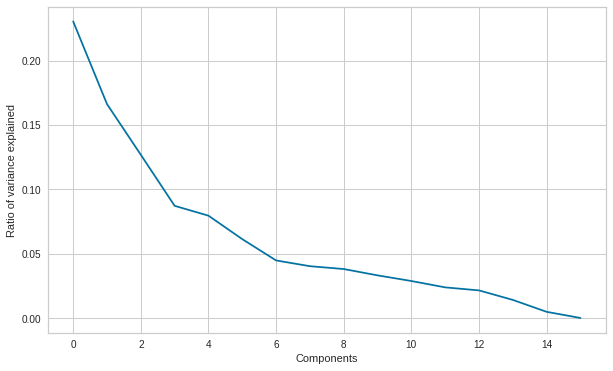

In [ ]:
pca.fit(x_baj)
#Obtenemos n componentes principales
proyected_features = pca.transform(x_baj)

print("Explained variance: ")
print(pca.explained_variance_.round(4))
print("Explained variance ratio")
print(pca.explained_variance_ratio_.round(4))
  #proyected_features.shape

  #Porcentaje  de varianza para los primeros n componentes principales
fig = plt.figure(figsize=(10,6))
sns.lineplot(x=range(pca.n_components),
                  y=pca.explained_variance_ratio_,)

plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")

porcentaje=0.95
suma=0
for component in range(pca.n_components):

  suma+=pca.explained_variance_ratio_[component]
  if suma>=porcentaje:
    #print(component)
    break
print(component,suma)


12 componentes explican el 95% de la varianza y las primeras 4 componentes explican más del 50% de la varianza

In [ ]:
#Grafico

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

PCA_coins =go.Scatter(x=proyected_features[:,0], y=proyected_features[:,1],name='Coins',
                      text=x_baj.index,
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[1],size=7),mode='markers+text')

data=[PCA_coins]

layout = go.Layout(title="PCA",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)


In [ ]:
fig.show(renderer="colab")

In [ ]:
#Grafico

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

PCA_coins =go.Scatter(x=proyected_features[:,1], y=proyected_features[:,2],name='Coins',
                      text=x_baj.index,
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[1],size=7),mode='markers+text')

data=[PCA_coins]

layout = go.Layout(title="PCA",titlefont=dict(size=20),
                xaxis=dict(title='Componente 2'),
                yaxis=dict(title='componente 3'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)

In [ ]:
fig.show(renderer="colab")

#### **Con datos Escalados**

In [ ]:
x_baj_sca=StandardScaler().fit_transform(df_estudio_bajista).transpose()

In [ ]:
x_baj_sca.shape

(16, 216)

Explained variance: 
[12.3074 10.0574  8.088   6.6978  5.1109  4.8918  4.4607  4.118   3.4495
  2.9053  2.6194  2.0277  1.7989  1.4896  1.1664  0.    ]
Explained variance ratio
[0.1729 0.1413 0.1136 0.0941 0.0718 0.0687 0.0627 0.0578 0.0485 0.0408
 0.0368 0.0285 0.0253 0.0209 0.0164 0.    ]
13 0.9626901779370626


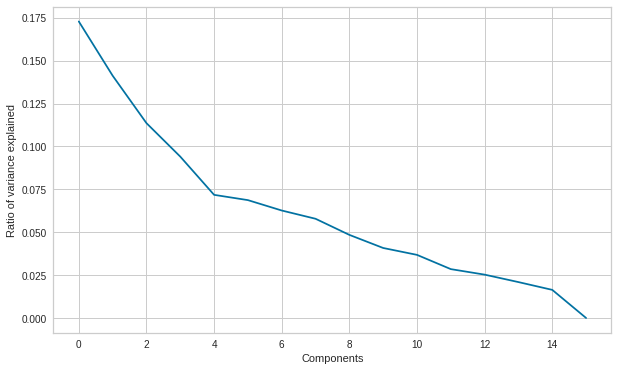

In [ ]:
pca.fit(x_baj_sca)

#Obtenemos n componentes principales
proyected_features_sca = pca.transform(x_baj_sca)

print("Explained variance: ")
print(pca.explained_variance_.round(4))
print("Explained variance ratio")
print(pca.explained_variance_ratio_.round(4))

  #Porcentaje  de varianza para los primeros n componentes principales
fig = plt.figure(figsize=(10,6))
sns.lineplot(x=range(pca.n_components),
                  y=pca.explained_variance_ratio_,)

plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")

porcentaje=0.95
suma=0
for component in range(pca.n_components):

  suma+=pca.explained_variance_ratio_[component]
  if suma>=porcentaje:
    #print(component)
    break
print(component+1,suma)


14 componentes explican el 95% de la varianza

In [ ]:
#Grafico

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

PCA_coins =go.Scatter(x=proyected_features_sca[:,0], y=proyected_features_sca[:,1],name='Coins',
                      text=x_alc.index,
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[1],size=7),mode='markers+text')

data=[PCA_coins]

layout = go.Layout(title="PCA",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)


In [ ]:
fig.show(renderer="colab")

### **Kmeans al resultado de PCA**

In [ ]:
from sklearn.cluster import KMeans

X = proyected_features_alc
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.labels_
centros=kmeans.cluster_centers_

#### **Grafico con 3 componentes**

In [ ]:
df_centros=pd.DataFrame()
df_centros['x']=centros[:,0]
df_centros['y']=centros[:,1]
df_centros['z']=centros[:,2]
df_centros['prediction']=pd.DataFrame(centros).index
df_centros['name']=np.array(['Cluster nº1','Cluster nº2','Cluster nº3'])

In [ ]:
df_grafico=pd.DataFrame()
df_grafico['x']=proyected_features_alc[:,0]
df_grafico['y']=proyected_features_alc[:,1]
df_grafico['z']=proyected_features_alc[:,2]
df_grafico['name']=coins
df_grafico['prediction']=kmeans.labels_

In [ ]:
plot_clustering(df_grafico,df_centros)

In [ ]:
df_grafico.sort_values(by='prediction')

,x,y,z,name,prediction
1,2.013311,-6.427080,3.416566,ADAUSDT,0
2,-6.897091,1.391582,-1.551387,BCHUSDT,0
4,-5.558510,11.129207,-8.198754,BTCUSDT,0
6,-5.920562,-3.811030,5.811084,DASHUSDT,0
8,-3.455512,-4.835374,-0.162491,EOSUSDT,0
9,-5.564021,-4.487954,3.167882,ETCUSDT,0
10,2.481360,4.739988,-8.270498,ETHUSDT,0
11,2.456167,-1.862569,-3.510863,LINKUSDT,0
12,-5.812482,2.213521,-5.233070,LTCUSDT,0
14,-2.310047,-4.887283,1.352968,NEOUSDT,0


### **Conclusión**

Se ve que con datos escalados son necesarias más componentes para explicar más variabilidad, por lo que pierde un poco de visibilidad la separación de los datos en las 2 o 3 dimensiones, observandose con datos no escalados clusters más agrupados y con los datos escalados se separan un poco más. 

PCA ayuda a visualizar mejor las separaciones, dando resultados similares a los anteriores.

Se observan resultadoas similares con todos los metodos, siendo el más interpretable el metodo de clustering jerarquico.

